In [1]:
################################# NEW CODE ########################
from temp_utils.opconNosepokeFunctions import *
from temp_utils.supplementaryFunctions import *
from scipy.optimize import minimize
from scipy.stats import entropy
from scipy.stats import ttest_rel
# sessdf = pd.read_csv('L:/4portProb_processed/sessdf.csv')
# sessdf.drop(columns = 'Unnamed: 0', inplace = True)

# window = 7
# exclude = ['[ 20  20  20 100]', '[0 0 0 0]', '[0]', '[0 0]',
#        '[1000   80]', '[30]', '[40]', '[70]']
# sessdf = sessdf[~sessdf.rewprobfull.isin(exclude)]
# sessdf = sessdf[~sessdf.duplicated(subset = ['animal', 'session', 'trialstart', 'eptime'], keep = False)]
# sessdf['rr'] = sessdf.groupby(['animal', 'session'], as_index = False).reward.rolling(window, center=True).mean().reward

<Figure size 640x480 with 0 Axes>

In [ ]:
from qlfittingFunctions import *
import multiprocessing as mp
def data_prep(dataset, hist = 20, trialsinsess=75, task = 'unstr', head = False):
    dataset = dataset.groupby(['animal','session']).filter(lambda x: x.reward.size >= trialsinsess)
    dataset['choice_t0'] = dataset.port.values

    dataset = dataset.dropna()
    if head == True:
        dataset = dataset.groupby(['animal','session']).head(trialsinsess)

    return dataset
mask = (sessdf.task.isin(['unstr']))
sessdf['sess_bin'] = sessdf.groupby(['animal', 'task'])['session'].transform(lambda x: pd.cut(x, bins=range(0, x.max() + 50, 50), labels=False, right=False)+1)

sessdf_prep = data_prep(sessdf[mask], hist = 1, trialsinsess = 100, head= True)
sess_dict = {key: group for key, group in sessdf_prep.groupby('animal')}

# NOTE:: all sim parameters moved to NAS 

# pyBADS

In [ ]:
def nllucbQlearning(x0, sessdf, arms):
    alpha, tau, c = x0
    ll = 0
    
    p = np.zeros(len(sessdf))
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        counter = np.ones(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            ucb = c*np.sqrt((np.log(sum(counter))/counter))
            P = np.exp(invtemp*(q+ucb))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of selected action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            counter[index] = counter[index]+1
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [5]:
# sessdf_prep = sessdf.copy(deep=True)
####################### OLD DATA LOADER #######################
# sessdf_prep = data_prep(sessdf, hist = 1, trialsinsess = 100, head= True)
# mask = (sessdf_prep.task.isin(['unstr']))
# sessdf_prep = sessdf_prep[(sessdf_prep.sess_bin>=4) & mask]
# test_sess_dict = {}
# for animal in sessdf_prep.animal.unique():
#     unique_sess = sessdf_prep[sessdf_prep.animal == animal].session.nunique()
#     test_sess = np.random.choice(sessdf_prep[sessdf_prep.animal == animal].session.unique(), int(unique_sess*0.2), replace = False)
#     test_sess_dict[animal] = test_sess
#     sessdf_prep.drop(sessdf_prep[(sessdf_prep.animal == animal) & (sessdf_prep.session.isin(test_sess))].index, inplace = True)

# late_data_bin_dict = {key: group for key, group in sessdf_prep.groupby('animal')}

# new

import pickle 
with open('C:/Users/dlab/Downloads/cleandf.pkl', 'rb') as f:
    sessdf = pickle.load(f)

# subset for expert performance
subset_df = sessdf[(sessdf.sess_bin>=4) & (sessdf.task == 'unstr')]
from temp_utils.dfLoading import subset_trials, add_block_groups

# add block groups and select only first block 
subset_df = add_block_groups(subset_df)
first_block_df = subset_df[subset_df.block_group==1]

trialsinsess = 100
# then subset for first 100 trials
subset_df = subset_trials(subset_df, trialsinsess=trialsinsess, head_trials = trialsinsess)
first_block_df = subset_trials(first_block_df, trialsinsess=trialsinsess, head_trials=trialsinsess)


np.random.seed(42)

test_sess_dict = {}
# pick 10% sessions for testing
for animal in subset_df.animal.unique():
    unique_sess = subset_df[subset_df.animal == animal].session.nunique()
    test_sess = np.random.choice(subset_df[subset_df.animal == animal].session.unique(), int(unique_sess*0.2), replace = False)
    test_sess_dict[animal] = test_sess
    # subset_df.drop(subset_df[(subset_df.animal == animal) & (subset_df.session.isin(test_sess))].index, inplace = True)

sess_dict = {key: group for key, group in subset_df.groupby('animal')}

test_sess_dict_first_block = {}
for animal in first_block_df.animal.unique():
    unique_sess = first_block_df[first_block_df.animal == animal].session.nunique()
    test_sess = np.random.choice(first_block_df[first_block_df.animal == animal].session.unique(), int(unique_sess*0.2), replace = False)
    test_sess_dict_first_block[animal] = test_sess
    # first_block_df.drop(first_block_df[(first_block_df.animal == animal) & (first_block_df.session.isin(test_sess))].index, inplace = True)

first_block_sess_dict = {key: group for key, group in first_block_df.groupby('animal')}
print('loaded data')

c:\Users\dlab\rishika_sim\models\fit_ratdata_to_ql\temp_utils\dfLoading.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = 0
c:\Users\dlab\rishika_sim\models\fit_ratdata_to_ql\temp_utils\dfLoading.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sess_block'] = df.groupby(['animal', 'task']).sess_block.cumsum()
c:\Users\dlab\rishika_sim\models\fit_ratdata_to_ql\temp_utils\dfLoading.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


loaded data


In [ ]:
# typical usage:
# from pybads import BADS
# # ...
# bads = BADS(target, x0, lb, ub, plb, pub)
# optimize_result = bads.optimize()
# data = None # define your data
# extra_params = None # define your function-specific parameters

# def fun_for_pybads(x):
#   return fun(x, data, extra_params)

# # Pass fun_for_pybads to PyBADS

from pybads import BADS
# data = sess_dict['Quilava']
data = late_data_bin_dict['Eevee']
extra_params = 4
results = {}
plausible_lower_bounds = np.array([0, 0.0001])
plausible_upper_bounds = np.array([1, 100])
# for animal in sess_dict.keys():
#     data = sess_dict[animal]
def fun_for_pybads(x):
    return nllucbQlearning(x, data, extra_params)
options = {'random_seed': 0}
bads = BADS(fun_for_pybads,
            [0.1, 0.1, 0.1, 0.1, 0.01], [-1.0, -1.0, -1.0, -1.0, 0.0015], [1.0, 1.0, 1.0, 1.0, 100], options = options)
            # plausible_lower_bounds=plausible_lower_bounds,
            # plausible_upper_bounds=plausible_upper_bounds)
optimize_result = bads.optimize()
    # results[animal] = [optimize_result.x, optimize_result.fval, optimize_result.success]


## load all fitted params

In [3]:
import re
import pandas as pd
import numpy as np
import io
def read_fits(filepath):
    with open(filepath, "r") as myfile:
        p_data = myfile.read()

    if filepath == r"L:\4portProb_simulations\model_parameters_20250322\alphamat_stickymat_v2.csv":
        # Remove any existing newline characters
        p_data = p_data.replace('\n', '').replace('\r', '')

        # Replace '@' with newline characters
        s = p_data.replace('@', '\n')
        
    else:
        # Join the data into a single string
        s = ' '.join(p_data.splitlines())
        # Insert a newline after every 7 comma-separated values
        s = re.sub(r'((?:[^,]*,){6}[^,]*)(?=\s|$)', r'\1\n', s)
  
    # Read the modified string with pandas
    df = pd.read_csv(io.StringIO(s), header=None)

    # Define the column names
    df.columns = ['animal', 'iter', 'params', 'nll', 'success', 'test_set', 'bic']

    # remove whitespace from df['animal']
    if df['animal'].dtype == 'object':
        df['animal'] = df['animal'].str.strip()

    def string_to_array(s):
        # Extract numbers using regex
        numbers = re.findall(r'[-+]?\d*\.\d+(?:e[-+]?\d+)?|[-+]?\d+', s)
        # Convert to numpy array
        return np.array(numbers, dtype=float)

    # Apply the function to the 'params' column
    df['params_array'] = df['params'].apply(string_to_array)
    params = [df.loc[i, 'params_array'] for i in range(df.shape[0])]
    params = np.array(params)
    return df, params

# df_vanilla, params_vanilla = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\vanillaQL_v2.csv")
# df_sticky, params_sticky = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\stickyQL_v2.csv")
# df_alpha2, params_alpha2 = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_2Q_v2.csv")
# df_alpha2_sticky, params_alpha2_sticky = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alpha2Q_sticky_v2.csv")
# df_alpha2_stickyscaled, params_alpha2_stickyscaled = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alpha2Q_stickyscaled_v2.csv")
# df_alpha2_stickyscaled_bias, params_alpha2_stickyscaled_bias = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alpha2Q_stickyscaled_bias_v2.csv")
# df_alpha2_stickyscaled_array, params_alpha2_stickyscaled_array = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alpha2Q_stickyscaledarray_v2.csv")
# df_alphamat, params_alphamat = read_fits(r'L:\4portProb_simulations\model_parameters_20250826\alphamat_first_block_bads.csv')
# df_alphamat_sticky, params_alphamat_sticky = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_sticky_randomstart_v2.csv")
# df_alphamat_stickymat, params_alphamat_stickymat = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_stickymat_v2.csv")
# df_alphamat_stickyscaled, params_alphamat_stickyscaled = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\alphamat_stickyscaled_first_block_bads.csv")
# df_alphamat_trialsticky, params_alphamat_trialsticky = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\alphamat_trialsticky_first_block_50_bads.csv")
# df_alphamat_stickyscaled_bias, params_alphamat_stickyscaled_bias = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_stickyscaled_bias_v2.csv")
# df_alphamat_stickyscaled_array, params_alphamat_stickyscaled_array = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_stickyscaledarray_v2.csv")
# df_structured, params_structured = read_fits(r"L:\4portProb_simulations\model_parameters_20250322\alphamat_structured.csv")
# df_alphamat2, params_alphamat2 = read_fits(r"L:\4portProb_simulations\model_parameters_20250816\alphamat_randomstart_v2.csv")
# df_thompson, params_thompson = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\thompson_first_block_bads.csv")
# df_thompson_mod, params_thompson_mod = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\thompson_mod_first_block_bads.csv")
# df_thompson_f, params_thompson_f = read_fits(r"L:\4portProb_simulations\model_parameters_20250816\thompson_forgetting_bounds_v2.csv")
# df_tblocked, params_tblocked = read_fits(r"L:\4portProb_simulations\model_parameters_20250816\thompson_blocked_v4.csv")
# df_tunblocked, params_tunblocked = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\thompson_unblocked_bads.csv")
# df_tunblocked_de, params_tunblocked_de = read_fits(r"L:\4portProb_simulations\model_parameters_20250826\thompson_unblocked_de.csv")
# df_alphamat_de, params_alphamat_de = read_fits(r'L:\4portProb_simulations\model_parameters_20250826\alphamat_unblocked_de.csv')
df_gp, params_gp = read_fits(r'S:\fileTransferFromWindows\output_2025-10-15_gp.csv')
df_gp_dls, params_gp_dls = read_fits(r'S:\fileTransferFromWindows\output_2025-10-23_15-51-43.csv')

df_stickygp, params_stickygp = read_fits(r'S:\fileTransferFromWindows\output_2025-10-16_stickygp.csv')
df_bayesucb, params_ucb = read_fits(r'S:\fileTransferFromWindows\output_2025-10-04_bayesucb.csv')
df_stickybayesucb, params_stickyucb = read_fits(r'S:\fileTransferFromWindows\output_2025-10-06_stickybayesucb.csv')
df_localpol, params_localpol = read_fits(r'S:\fileTransferFromWindows\output_2025-10-16_localpol.csv')


In [4]:
np.random.seed(42)
# print(params_gp[np.random.choice(np.arange(26))])
print(np.mean(params_gp, axis = 0))
print(np.median(params_gp, axis = 0))

[0.22371286 0.06530575 0.91504788]
[0.         0.0015     1.07512751]


In [365]:
plt.figure()
plt.bar(df_localpol.groupby('animal').nll.idxmin().index, df_localpol.groupby('animal').nll.min() - df_gp.groupby('animal').nll.min())
plt.xticks(rotation = 90)
plt.ylabel('Delta NLL (LocalPol - GPC)')
plt.tight_layout()

In [384]:
from temp_utils.plotSettings import *
%matplotlib qt
plt.figure(figsize = (12,5))
model_names = ['GP', 'stGP', 'localPol', 'stB-UCB', 'B-UCB']
# merge 4 dataframes
merged_df = pd.concat([df_gp, df_stickygp, df_localpol, df_stickybayesucb, df_bayesucb], keys = model_names).reset_index().rename(columns = {'level_0':'model'})

sns.barplot(
    merged_df.groupby(['model', 'animal'], as_index=False).nll.min(),
     x = 'animal', 
     y = 'nll', hue = 'model', 
     hue_order=model_names, 
     palette=['xkcd:blue','xkcd:dark blue', 'xkcd:red', 'xkcd:green', 'xkcd:forest'])
plt.xticks(rotation = 90)
plt.title('Training NLL')
plt.tight_layout()

In [ ]:
plt.figure()
sns.barplot(df_gp.groupby('animal').nll.min(), alpha = 0.5, label = 'GPC')
sns.barplot(df_thompson_mod.groupby('animal').nll.min(), alpha = 0.5, label = 'TS')
sns.barplot(df_alphamat.groupby('animal').nll.min(), alpha = 0.5, label = '4aQL')
sns.barplot(df_alphamat_trialsticky.groupby('animal').nll.min(), alpha = 0.5, label = '4a+stQL')
plt.xticks(rotation = 90)
plt.legend()
plt.tight_layout()

In [395]:
sns.boxplot(mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :])

<Axes: >

In [5]:
%matplotlib qt
from temp_utils.plotSettings import *
from scipy.stats import sem
plt.figure(figsize = (4, 5))
mat = params_gp
df = df_gp[df_gp.animal.isin(df_gp_dls.animal.unique())]
# mat = params_gp_dls
# df = df_gp_dls
plt.bar(np.arange(3), np.mean(mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], axis = 0), yerr = sem(mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], axis = 0, nan_policy ='omit'), color = 'xkcd:avocado')
plt.xticks(np.arange(3), [r'$\beta$'+'\nuncertainty', r'$\tau$'+'\ntemperature', r'$\lambda$'+'\nlength scale'], rotation = 15)
plt.ylabel('GP-UCB parameter value')
plt.tight_layout()

In [70]:
def compare_generalization_local(x0, df, arms, trialsinsess):

    tau, c, wt, sig = x0
    alpha0, beta0 = 1, 1
    ll = 0
    chosen_action = df.port.to_numpy().reshape(-1, trialsinsess)
    rewarded = df.reward.to_numpy().reshape(-1, trialsinsess)
    sessions = chosen_action.shape[0]
    p = np.zeros(shape = (sessions, trialsinsess))
    P = np.ones(shape = (sessions, trialsinsess, arms))*1e-7
    q = np.ones(shape = (sessions, trialsinsess, arms))*1e-7

    for sess in range(sessions):
        alphas = np.ones(arms)*alpha0
        betas = np.ones(arms)*beta0
        for trial in range(trialsinsess):
            # check if sess restarted
            # if sess_start == True:
            #     # if group.block_group.unique()[0] == 1:
            #     
            # sess_start = False

            # calc expectation of each arm being selected (alp/ alp+beta)
            q[sess, trial, :] = alphas/(alphas+betas)
            ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

            # add a parameter for decay around stick
            if trial>0:
                prev_chosen = int(chosen_action[sess, trial-1])-1
                x = np.array([0,1,2,3])
                locality = np.exp(-0.5*((x-prev_chosen)/sig)**2)
            else: locality = 0

            # softmax prob of choosing actions
            invtemp=1/tau
            input_to_softmax = (invtemp*(q[sess, trial, :]+(c*ucb)))+(wt*locality)
            P[sess, trial, :] = np.exp(input_to_softmax - max(input_to_softmax))
            P[sess, trial, :] = P[sess, trial, :]/ np.sum(P[sess,trial, :]) 
            P[sess, trial, :] = np.clip(P[sess, trial, :], a_min = 1e-7, a_max = None)

            # which action on this trial
            a = chosen_action[sess, trial]
            chosen = int(a-1)

            # probability of selected action on this trial
            p[sess, trial] = P[sess, trial, chosen]

            # rewarded?
            r = rewarded[sess, trial]

            # increment alphas and betas
            alphas[chosen] += r+alpha0
            betas[chosen] += (1-r)+beta0

            # # check how many trials elapsed
            # if trial == session_ends.iloc[sess_num]:
            #     sess_start=True
            #     sess_num += 1


    p[p == 1e-7] = np.nan

    nll = -np.log(p)
    nll_mat = nll.reshape(-1, 100)
    print(np.nansum(nll))

    # prob_mean = q.reshape(-1, 100, 4)
    prob_mean = q
    prob_mean[prob_mean == 1e-7] = np.nan
    n_sessions = prob_mean.shape[0]
    n_trials = prob_mean.shape[1]

    curr_a = chosen_action#.reshape(-1, 100)-1
    prev_a = np.full_like(curr_a, np.nan)
    prev_a[:, 1:] = curr_a[:, :-1]
    dist_moved = np.abs(curr_a - prev_a)

    curr_q = prob_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)-1]
    next_mean = np.full_like(prob_mean, np.nan)
    next_mean[:, :-1, :] = prob_mean[:, 1:, :]
    next_q = next_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)-1]

    curr_r = rewarded#.reshape(-1, 100)
    prev_r = np.zeros_like(curr_r)
    prev_r[:, 1:] = curr_r[:, :-1]

    l = []
    # now compute difference between each of these trials, and condition by distance and by outcome condition
    for distance in [0,1,2]:
        mask_NR = (curr_r == 1) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        mask_RR = (curr_r == 1) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_RN = (curr_r == 0) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_NN = (curr_r == 0) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        l.append(np.nanmean(curr_r[mask_NR[:, :len_sess]] - curr_q[mask_NR[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_RR[:, :len_sess]] - curr_q[mask_RR[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_RN[:, :len_sess]] - curr_q[mask_RN[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_NN[:, :len_sess]] - curr_q[mask_NN[:, :len_sess]]))
    return prob_mean, curr_a, curr_r, l
len_sess = 100
gen_mat_local = np.zeros(shape = (len(df_localpol.animal.unique()), 12))
rpes = np.ones(shape = (gen_mat_local.shape[0], 4, 4))*np.nan
ind = 0
for animal in df_localpol.animal.unique():
    if df_localpol[df_localpol.animal == animal].params_array.shape[0]>0:
        fit_params = params_localpol[df_localpol.loc[df_localpol[df_localpol.animal == animal].groupby('animal')['nll'].idxmin()].index, :].flatten()
        prob_mean, curr_a, curr_r, gen_mat_local[ind, :] = compare_generalization_local(fit_params, first_block_sess_dict[animal], 4, len_sess)
        # to identify if model generalizes or not:
        # next_mean = np.full_like(prob_mean, np.nan)
        # next_mean[:, :-1, :] = prob_mean[:, 1:, :]
        # rpe_mat = next_mean - prob_mean

        # l = []
        n_sessions, n_trials, n_actions = prob_mean.shape

        # ashesh's method of calc
        
        qa_c = np.zeros_like(curr_r)
        for sess in range(n_sessions):
            for trial in range(n_trials):
                qa_c[sess, trial] = prob_mean[sess, trial, int(curr_a[sess, trial]-1)]

        diff_choices = np.abs(np.concatenate([np.zeros(shape = (curr_a.shape[0], 1)), np.diff(curr_a, axis = 1)], axis = 1))
        diff_rewards = np.concatenate([np.zeros(shape = (curr_r.shape[0], 1)), np.diff(curr_r, axis = 1)], axis = 1)

        for d in range(1, n_actions+1):
            nn = (diff_rewards == 0) & (curr_r == 0)
            rn = (diff_rewards == -1)
            nr = (diff_rewards == 1)
            rr = (diff_rewards == 0) & (curr_r == 1)
            d_c = (diff_choices==d-1)

            rpes[ind, d-1, 0] = np.nanmean(curr_r[nn & d_c] - qa_c[nn & d_c])
            rpes[ind, d-1, 1] = np.nanmean(curr_r[rn & d_c] - qa_c[rn & d_c])
            rpes[ind, d-1, 2] = np.nanmean(curr_r[nr & d_c] - qa_c[nr & d_c])
            rpes[ind, d-1, 3] = np.nanmean(curr_r[rr & d_c] - qa_c[rr & d_c])
        ind+=1
        # for distance in [0, 1, 2]:
        #     # For each trial, get the RPE at chosen arm ± distance
        #     rpe_at_dist = np.full((n_sessions, n_trials), np.nan)
        #     for sess in range(n_sessions):
        #         for t in range(n_trials):
        #             idx = int(curr_a[sess, t])
        #             # Only use valid indices
        #             target_idx = idx + distance
        #             if 0 <= target_idx < n_actions:
        #                 rpe_at_dist[sess, t] = rpe_mat[sess, t, target_idx]
        #     # Now analyze by reward outcome
        #     l.append(np.nanmean(rpe_at_dist[curr_r == 1]))
        #     l.append(np.nanmean(rpe_at_dist[curr_r == 0]))

        # plt.plot(l[::2], label='R', color='xkcd:red', marker='o', lw = 3)
        # plt.plot(l[1::2], label='N', color='xkcd:blue', marker='o', lw = 3)
        # plt.axhline(0, color = 'k', lw = 0.75, ls = '-')
        # plt.xticks(np.arange(3), np.arange(3))
        # plt.ylabel('RPE')
        # plt.xlabel('Distance from chosen action')
        # # plt.legend()
        # plt.tight_layout()
        

4990.329912965062
18930.89922658232


C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:133: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 1] = np.nanmean(curr_r[rn & d_c] - qa_c[rn & d_c])


5085.369002333464


C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:135: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 3] = np.nanmean(curr_r[rr & d_c] - qa_c[rr & d_c])


8792.025540817169
2066.8795762073964
12128.577469736978
4183.675041763558
14472.944963264055
16439.145128492582
6637.646915240974
6716.278329590291
1164.9715334240996


C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:95: RuntimeWarning: Mean of empty slice
  l.append(np.nanmean(curr_r[mask_RR[:, :len_sess]] - curr_q[mask_RR[:, :len_sess]]))
C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:135: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 3] = np.nanmean(curr_r[rr & d_c] - qa_c[rr & d_c])
C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:132: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 0] = np.nanmean(curr_r[nn & d_c] - qa_c[nn & d_c])
C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:133: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 1] = np.nanmean(curr_r[rn & d_c] - qa_c[rn & d_c])
C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:134: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 2] = np.nanmean(curr_r[nr & d_c] - qa_c[nr & d_c])


7958.787982982074
13069.681127243317
10256.027233362165
4798.336314721027
6908.838389600531
1307.182775212887


C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\501214673.py:135: RuntimeWarning: Mean of empty slice
  rpes[ind, d-1, 3] = np.nanmean(curr_r[rr & d_c] - qa_c[rr & d_c])


7273.5728802426
10376.234352952277
6600.786862506273
9453.166363353605
14306.150553543683
9837.738601680441
7796.2984188670025
10145.118208858696


<BarContainer object of 4 artists>

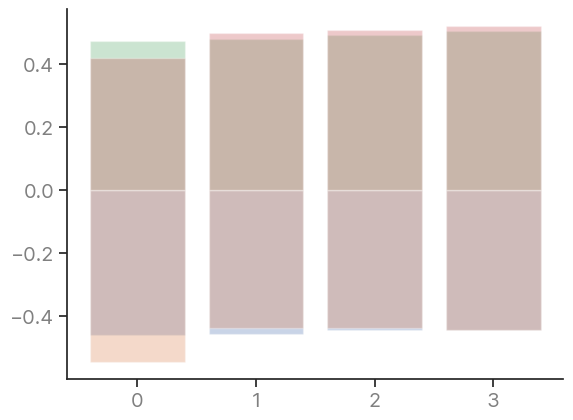

In [91]:
plt.bar(x = [0, 1, 2, 3], height = np.nanmedian(rpes, axis =0)[:, 0], alpha = 0.3)
plt.bar(x = [0, 1, 2, 3], height = np.nanmedian(rpes, axis =0)[:, 1], alpha = 0.3)
plt.bar(x = [0, 1, 2, 3], height = np.nanmedian(rpes, axis =0)[:, 2], alpha = 0.3)
plt.bar(x = [0, 1, 2, 3], height = np.nanmedian(rpes, axis =0)[:, 3], alpha = 0.3)

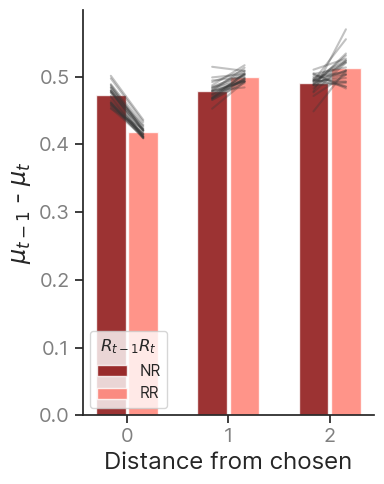

In [14]:
# import matplotlib.pyplot as plt
# from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_local[:, 0::4] >= 1e-3
data_NR = gen_mat_local[np.all(mask, axis=1)][:, 0::4]
mask = gen_mat_local[:, 1::4] >= 1e-3
data_RR = gen_mat_local[np.all(mask, axis=1)][:, 1::4]

distances = [0, 1, 2]
colors = ['xkcd:dark red', 'xkcd:salmon']
labels = ['NR', 'RR']
from temp_utils.plotSettings import *
plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label='NR', alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label='RR', alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
plt.ylabel(r'$\mu_{t-1}$ - $\mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$')
# plt.ylim(0.00, 0.08)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\RR_NR_GPC.svg')


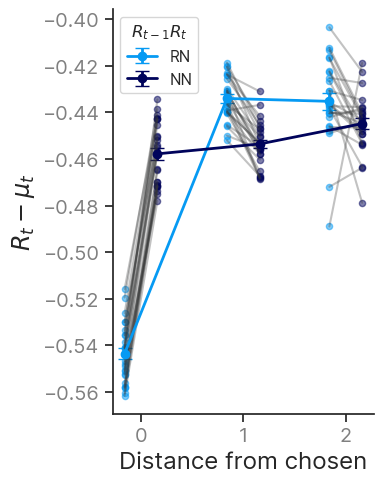

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_local[:, 2::4] <= -1e-3
data_RN = gen_mat_local[:, 2::4]  # RN
mask = gen_mat_local[:, 3::4] <= -1e-3
data_NN = gen_mat_local[:, 3::4]  # NN

distances = [0, 1, 2]
colors = ['xkcd:azure', 'xkcd:dark blue']
labels = ['RN', 'NN']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same

# Scatter and point plot for RN and NN
for i, (label, color, data) in enumerate(zip(labels, colors, [data_RN, data_NN])):
    # Scatter individual points
    for j in range(data.shape[0]):
        plt.scatter(xtick_base + (-offset if i == 0 else offset), data[j, :], color=color, alpha=0.5, s=20)
    # Point plot (mean ± sem)
    plt.errorbar(
        xtick_base + (-offset if i == 0 else offset),
        np.nanmean(data, axis=0),
        yerr=sem(data, axis=0, nan_policy='omit'),
        fmt='o-', color=color, label=label, capsize=5, lw=2
    )

# Pair RN and NN for each animal at each distance (draw lines only between RN and NN at the same distance)
for dist in range(3):
    for i in range(data_RN.shape[0]):
        plt.plot(
            [xtick_base[dist] - offset, xtick_base[dist] + offset],
            [data_RN[i, dist], data_NN[i, dist]],
            color='xkcd:dark grey', alpha=0.3
        )

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
plt.ylabel(r'$R_{t} - \mu_{t}$')
plt.legend(title = r'$R_{t-1}R_{t}$')
# plt.ylim(-0.01, 0)
plt.tight_layout()
plt.show()

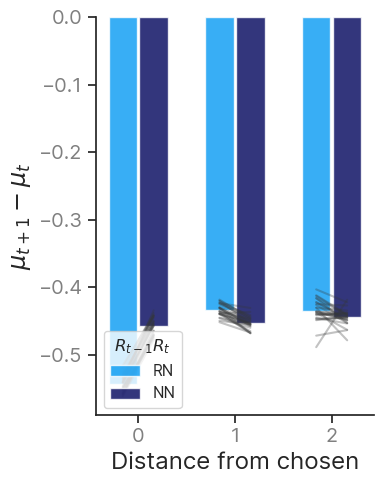

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_local[:, 2::4] <= -1e-3
data_NR = gen_mat_local[:, 2::4]#gen_mat_local_25[np.all(mask, axis=1)][:, 2::4]
mask = gen_mat_local[:, 3::4] <= -1e-3
data_RR = gen_mat_local[:, 3::4]#gen_mat_local_25[np.all(mask, axis=1)][:, 3::4]

distances = [0, 1, 2]
colors = ['xkcd:azure', 'xkcd:dark blue']
labels = ['RN', 'NN']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label=labels[0], alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label=labels[1], alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
plt.ylabel(r'$\mu_{t+1} - \mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$', loc = 'lower left')
# plt.ylim(-0.07, -0.)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\NR_NN_GPC.svg')
plt.show()


8795.505719423996
32849.23287111751
11032.392527433214
13512.001623689914
4844.281104977763
21739.34628434897
7460.495040792512
25000.35144984244
24708.356499822414
12897.295267845144
24920.751385333213
2341.042200753528


C:\Users\dlab\AppData\Local\Temp\ipykernel_18336\3432937768.py:86: RuntimeWarning: Mean of empty slice
  l.append(np.nanmean(curr_r[mask_RR[:, :len_sess]] - curr_q[mask_RR[:, :len_sess]]))


16602.912697774504
22787.617018599958
18414.12317126575
13944.94526205098
13094.47979778533
2259.3948947135764
14872.951022989491
20389.349204113223
13229.197554324048
18163.220744315957
21844.29397388324
21955.226203039885
16251.61777080234
17040.32681667351


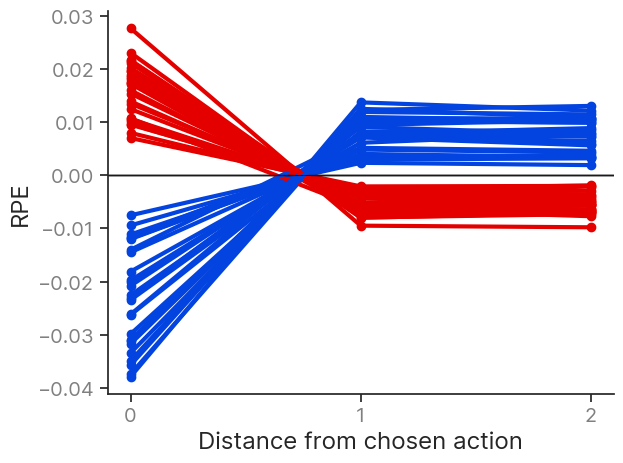

In [18]:
def compare_generalization_bucb(x0, df, arms, len_sess):

    tau, c = x0
    alpha0, beta0 = 1, 1
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.zeros(len(df))
    session_ends = np.cumsum(sessions)
    P = np.ones(shape = (len(df), arms))*1e-7
    
    sess_num = 0
    sess_start = True
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
        sess_start = False

        # calc expectation of each arm being selected (alp/ alp+beta)
        q = alphas/(alphas+betas)
        ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

        # softmax prob of choosing actions
        invtemp=1/tau
        input_to_softmax = (invtemp*(q+(c*ucb)))
        P[trial, :] = np.exp(input_to_softmax - max(input_to_softmax))
        P[trial, :] = P[trial, :]/ np.sum(P[trial, :]) 
        P[trial, :] = np.clip(P[trial, :], a_min = 1e-6, a_max = None)

        # which action on this trial
        a = chosen_action[trial]
        chosen = int(a-1)

        # probability of selected action on this trial
        p[trial] = P[trial, chosen]

        # rewarded?
        r = rewarded[trial]

        # increment alphas and betas
        alphas[chosen] += r+alpha0
        betas[chosen] += (1-r)+beta0

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1


    p[p == 1e-7] = np.nan

    nll = -np.log(p)
    nll_mat = nll.reshape(-1, 100)
    print(np.nansum(nll))

    prob_mean = P.reshape(-1, 100, 4)
    prob_mean[prob_mean == 1e-7] = np.nan
    n_sessions = prob_mean.shape[0]
    n_trials = prob_mean.shape[1]

    curr_a = chosen_action.reshape(-1, 100)-1
    prev_a = np.full_like(curr_a, np.nan)
    prev_a[:, 1:] = curr_a[:, :-1]
    dist_moved = np.abs(curr_a - prev_a)

    curr_q = prob_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]
    next_mean = np.full_like(prob_mean, np.nan)
    next_mean[:, :-1, :] = prob_mean[:, 1:, :]
    next_q = next_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]

    curr_r = rewarded.reshape(-1, 100)
    prev_r = np.full_like(curr_r, np.nan)
    prev_r[:, 1:] = curr_r[:, :-1]

    l = []
    # now compute difference between each of these trials, and condition by distance and by outcome condition
    for distance in [0,1,2]:
        mask_NR = (curr_r == 1) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        mask_RR = (curr_r == 1) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_RN = (curr_r == 0) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_NN = (curr_r == 0) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        l.append(np.nanmean(curr_r[mask_NR[:, :len_sess]] - curr_q[mask_NR[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_RR[:, :len_sess]] - curr_q[mask_RR[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_RN[:, :len_sess]] - curr_q[mask_RN[:, :len_sess]]))
        l.append(np.nanmean(curr_r[mask_NN[:, :len_sess]] - curr_q[mask_NN[:, :len_sess]]))
    return prob_mean, curr_a, curr_r, l
len_sess = 100
gen_mat_bucb = np.zeros(shape = (len(df_bayesucb.animal.unique()), 12))
ind = 0
for animal in df_bayesucb.animal.unique():
    if df_bayesucb[df_bayesucb.animal == animal].params_array.shape[0]>0:
        fit_params = params_ucb[df_bayesucb.loc[df_bayesucb[df_bayesucb.animal == animal].groupby('animal')['nll'].idxmin()].index, :].flatten()
        prob_mean, curr_a, curr_r, gen_mat_bucb[ind, :] = compare_generalization_bucb(fit_params, first_block_sess_dict[animal], 4, len_sess)
        next_mean = np.full_like(prob_mean, np.nan)
        next_mean[:, :-1, :] = prob_mean[:, 1:, :]
        rpe_mat = next_mean - prob_mean

        l = []
        n_sessions, n_trials, n_actions = rpe_mat.shape

        for distance in [0, 1, 2]:
            # For each trial, get the RPE at chosen arm ± distance
            rpe_at_dist = np.full((n_sessions, n_trials), np.nan)
            for sess in range(n_sessions):
                for t in range(n_trials):
                    idx = int(curr_a[sess, t])
                    # Only use valid indices
                    target_idx = idx + distance
                    if 0 <= target_idx < n_actions:
                        rpe_at_dist[sess, t] = rpe_mat[sess, t, target_idx]
            # Now analyze by reward outcome
            l.append(np.nanmean(rpe_at_dist[curr_r == 1]))
            l.append(np.nanmean(rpe_at_dist[curr_r == 0]))

        plt.plot(l[::2], label='R', color='xkcd:red', marker='o', lw = 3)
        plt.plot(l[1::2], label='N', color='xkcd:blue', marker='o', lw = 3)
        plt.axhline(0, color = 'k', lw = 0.75, ls = '-')
        plt.xticks(np.arange(3), np.arange(3))
        plt.ylabel('RPE')
        plt.xlabel('Distance from chosen action')
        # plt.legend()
        plt.tight_layout()
        ind+=1

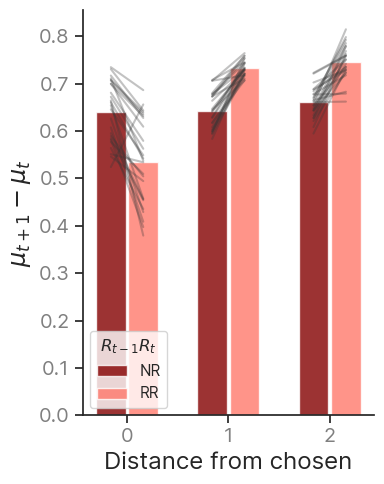

In [19]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_bucb[:, 0::4] >= 1e-3
data_NR = gen_mat_bucb[np.all(mask, axis=1)][:, 0::4]
mask = gen_mat_bucb[:, 1::4] >= 1e-3
data_RR = gen_mat_bucb[np.all(mask, axis=1)][:, 1::4]

distances = [0, 1, 2]
colors = ['xkcd:dark red', 'xkcd:salmon']
labels = ['NR', 'RR']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label='NR', alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label='RR', alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
plt.ylabel(r'$\mu_{t+1} - \mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$')
# plt.ylim(0., 0.05)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\RR_NR_GPC.svg')


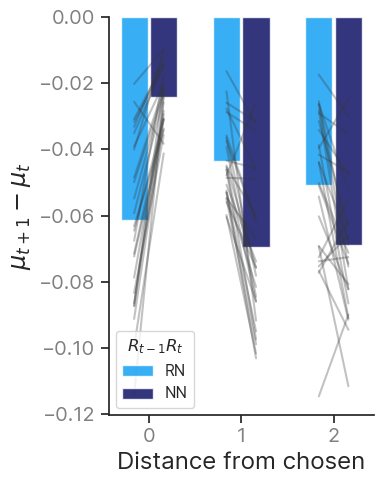

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_bucb_25[:, 2::4] <= -1e-3
data_NR = gen_mat_bucb_25[np.all(mask, axis=1)][:, 2::4]
mask = gen_mat_bucb_25[:, 3::4] <= -1e-3
data_RR = gen_mat_bucb_25[np.all(mask, axis=1)][:, 3::4]

distances = [0, 1, 2]
colors = ['xkcd:azure', 'xkcd:dark blue']
labels = ['RN', 'NN']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label=labels[0], alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label=labels[1], alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
plt.ylabel(r'$\mu_{t+1} - \mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$')
# plt.ylim(-0.05, 0)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\NR_NN_GPC.svg')
plt.show()


In [ ]:
def compare_generalization(x0, df, arms, len_sess):

    # session numbers
    sessions = df.session.value_counts()
    trials = len(df)
    u, temp, ls= x0
    b = 1/temp

    # create a kernel
    knl = Product(RBF(length_scale=ls), ConstantKernel(constant_value=1**2))

    # data info 
    chosen_action = df.port.to_numpy()-1
    curr_a = chosen_action.reshape(-1, 100)

    rewarded = df.reward.to_numpy()
    session_ends = np.cumsum(sessions)

    sess_num = 0
    sess_start = True
    mu_star = np.ones(shape = (chosen_action.shape[0], arms))*1e-7
    sd_star = np.zeros(shape = (chosen_action.shape[0], arms))

    # intialize storage
    nll = np.ones(len(df))*1e-7

    # for making predictions
    X = np.linspace(1,arms,arms).reshape(arms,1)

    for trial in range(chosen_action.shape[0]):

        # check if sess restarted
        if sess_start == True:
            gp = GaussianProcessClassifier(kernel = knl, optimizer = None)#, warm_start = True, multi_class='one_vs_one')
            start_trial = trial

        sess_start = False
        
        if len(np.unique(rewarded[start_trial:trial])) > 1:
        # if trial-start_trial>25:
            
            # what actions were taken so far
            a = chosen_action[start_trial:trial]

            # what rewards were given for each action
            r = rewarded[start_trial:trial]
            
            # update gp using all the info we got so far on a and r
            gp.fit(a.reshape(-1, 1), r)

            # get latent mean and variance
            mu, var = gp.latent_mean_and_variance(X)
            mu_star[trial, :] = expit(mu)
            sd_star[trial, :] = expit(np.sqrt(var))

            # create sticky param
            # prev_a = np.zeros(arms)
            # prev_a[int(chosen_action[trial - 1])] = 1 

            # calculate probability of taking any action
            input_to_softmax = (mu_star[trial, :]+u*sd_star[trial, :])*b#+ prev_a*h
            P = np.exp(input_to_softmax - max(input_to_softmax))
            P = P/ np.sum(P)
            P = np.clip(P, a_min = 1e-7, a_max = None)

            # what was probability of action taken?
            chosen = int(chosen_action[trial])
            nll[trial] = P[chosen]

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1

    nll[nll == 1e-7] = np.nan

    nll = -np.log(nll)
    nll_mat = nll.reshape(-1, 100)
    print(np.nansum(nll))

    prob_mean = mu_star.reshape(-1, 100, 4)
    prob_mean[prob_mean == 1e-7] = np.nan
    n_sessions = prob_mean.shape[0]
    n_trials = prob_mean.shape[1]

    curr_q = prob_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]
    next_mean = np.full_like(prob_mean, np.nan)
    next_mean[:, :-1, :] = prob_mean[:, 1:, :]
    next_q = next_mean[np.arange(n_sessions)[:, None], np.arange(n_trials)[None, :], curr_a.astype(int)]


    curr_a = chosen_action.reshape(-1, 100)
    prev_a = np.full_like(curr_a, np.nan)
    prev_a[:, 1:] = curr_a[:, :-1] 
    dist_moved = np.abs(curr_a - prev_a)


    curr_r = rewarded.reshape(-1, 100)
    prev_r = np.full_like(curr_r, np.nan)
    prev_r[:, 1:] = curr_r[:, :-1]

    l = []
    # now compute difference between each of these trials, and condition by distance and by outcome condition
    for distance in [0,1,2]:
        mask_NR = (curr_r == 1) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        mask_RR = (curr_r == 1) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_RN = (curr_r == 0) & (prev_r == 1) & (dist_moved == distance) #& valid_mask
        mask_NN = (curr_r == 0) & (prev_r == 0) & (dist_moved == distance) #& valid_mask
        l.append(np.nanmean((curr_r - curr_q)[:, :len_sess][mask_NR[:, :len_sess]]))
        l.append(np.nanmean((curr_r - curr_q)[:, :len_sess][mask_RR[:, :len_sess]]))
        l.append(np.nanmean((curr_r - curr_q)[:, :len_sess][mask_RN[:, :len_sess]]))
        l.append(np.nanmean((curr_r - curr_q)[:, :len_sess][mask_NN[:, :len_sess]]))
    return l
len_sess = 25
gen_mat_25 = np.zeros(shape = (len(df_gp.animal.unique()), 12))
ind = 0
for animal in df_gp.animal.unique():
    if df_gp[df_gp.animal == animal].params_array.shape[0]>0:
        fit_params = params_gp[df_gp.loc[df_gp[df_gp.animal == animal].groupby('animal')['nll'].idxmin()].index, :].flatten()
        gen_mat_25[ind, :] = compare_generalization(fit_params, first_block_sess_dict[animal], 4, len_sess)
        ind+=1

8287.942971526067
37808.59536815906
7817.607819648267
14740.136181454514
1791.4110137784733
21107.804381775237
7981.5391653397455
5927.918217909657
3086.694887054372
12869.71214035282
10181.032470289305
492.3542594767413


C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\4145317315.py:110: RuntimeWarning: Mean of empty slice
  l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_RR[:, :len_sess]]))
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\4145317315.py:111: RuntimeWarning: Mean of empty slice
  l.append(np.nanmean((next_q - curr_q)[:, :len_sess][mask_RN[:, :len_sess]]))


2430.9651269054475
12998.343679279953
12507.22984326391
6098.473588263445
10997.00076679692
304.03645977796003
13215.945866352737
10892.526702421534
16259.148030069151
7688.808061798011
13790.910868443329
3592.239336897808
11694.04803213355
4133.214913882139


In [517]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_25[:, 0::4] >= 1e-3
data_NR = gen_mat_25[np.all(mask, axis=1)][:, 0::4]
mask = gen_mat_25[:, 1::4] >= 1e-3
data_RR = gen_mat_25[np.all(mask, axis=1)][:, 1::4]

distances = [0, 1, 2]
colors = ['xkcd:dark red', 'xkcd:salmon']
labels = ['NR', 'RR']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label='NR', alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label='RR', alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
# plt.ylabel(r'$R_{t} - \mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$', loc = 'lower right')
plt.ylim(0, 0.05)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\RR_NR_GPC.svg')
plt.show()


In [521]:
import matplotlib.pyplot as plt
from scipy.stats import sem

# Prepare data for pairplot
mask = gen_mat_25[:, 2::4] <= -1e-3
data_NR = gen_mat_25[np.all(mask, axis=1)][:, 2::4]
mask = gen_mat_25[:, 3::4] <= -1e-3
data_RR = gen_mat_25[np.all(mask, axis=1)][:, 3::4]

distances = [0, 1, 2]
colors = ['xkcd:azure', 'xkcd:dark blue']
labels = ['RN', 'NN']

plt.figure(figsize=(4, 5))

# Reduce the distance between each xtick (make spacing half as wide)
xtick_base = np.arange(3) * 0.75  # spacing is now 0.5 instead of 1
offset = 0.12  # keep bar offset the same


# Plot average bars with error
width = 0.22
plt.bar(xtick_base - offset, np.nanmean(data_NR, axis=0), #yerr=sem(data_NR, axis=0, nan_policy='omit'),
        width=width, color=colors[0], label=labels[0], alpha=0.8)#, capsize=5)
plt.bar(xtick_base + offset, np.nanmean(data_RR, axis=0), #yerr=sem(data_RR, axis=0, nan_policy='omit'),
        width=width, color=colors[1], label=labels[1], alpha=0.8)#, capsize=5)

# Connect NR/RR pairs for each animal at each distance (keep grey lines)
for dist in range(3):
    for x, y in zip(data_NR[:, dist], data_RR[:, dist]):
        plt.plot([xtick_base[dist]-offset, xtick_base[dist]+offset], [x, y], color='xkcd:dark grey', alpha=0.3)

# Add text labels to bars
# for i, bar in enumerate(bars_NR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'NR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

# for i, bar in enumerate(bars_RR):
#     plt.text(bar.get_x() + bar.get_width()/2, 0.001, 'RR',
#              ha='center', va='bottom', rotation=90, fontsize=width*70, color='k')

plt.xticks(xtick_base, [str(d) for d in distances])
plt.xlabel('Distance from chosen')
# plt.ylabel(r'$R_{t} - \mu_{t}$')
# plt.title('NR/RR pairs by distance')
plt.legend(title = r'$R_{t-1}R_{t}$')
plt.ylim(-0.05)
plt.tight_layout()
# plt.savefig(r'C:\Users\dlab\OneDrive - Indian Institute of Science\Drawings\cosyne 2026\NR_NN_GPC.svg')
plt.show()


In [126]:
from temp_utils.plotSettings import *
%matplotlib qt
fig = plt.figure()
ax = plt.subplot(111)
mat = params_localpol
df = df_localpol
# '1diag', '2diag', '3diag',
# tick_labels = [r'$\alpha_0$', r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', r'$\tau$ = 1/$\beta$', 'trial_sticky']#, 'scaler', 'port 1', 'port 2', 'port 3', 'port 4']
# sns.violinplot(data = params_all, ax = ax)
sns.boxplot(data = mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], ax = ax)
sns.stripplot(data = mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], ax = ax, color = 'k', alpha = 0.5, jitter = False)
tick_labels = ['temp', 'ucb', 'h', 'sigma']
plt.xticks(ticks = np.arange(len(tick_labels)), labels = tick_labels)

([<matplotlib.axis.XTick at 0x202035f9090>,
 [Text(0, 0, 'temp'), Text(1, 0, 'ucb'), Text(2, 0, 'h'), Text(3, 0, 'sigma')])

In [51]:
sns.barplot(df_alphamat.loc[df_alphamat.groupby('animal')['nll'].idxmin()][['animal', 'nll']], x='animal', y = 'nll', alpha = 1, label = 'BADS')
sns.barplot(df_alphamat_de.loc[df_alphamat_de.groupby('animal')['nll'].idxmin()][['animal', 'nll']], x = 'animal', y = 'nll', alpha = 0.5, label = 'DE')
plt.xticks(rotation = 90)
plt.legend()
plt.tight_layout()

In [228]:
%matplotlib qt
from temp_utils.plotSettings import *

fig = plt.figure(figsize = (10, 5))
ax = plt.subplot(111)
mat = params_stickygp
df = df_stickygp
# '1diag', '2diag', '3diag',
tick_labels = [r'$\alpha_0$', r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', r'$\tau$ = 1/$\beta$', 'trial_sticky']#, 'scaler'#, 'port 1', 'port 2', 'port 3', 'port 4']'ArithmeticError
tick_labels = ['alpha0', 'beta0', 'w', 'l']

# sns.violinplot(data = mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], ax = ax)
sns.boxplot(data = mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], ax = ax)
sns.stripplot(data = mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :], ax = ax, color = 'k', alpha = 0.5)

ax.axhline(0, color ='k', linewidth = 0.5)
ax.set_xticks(range(mat.shape[1]), tick_labels, fontsize = 'large', color = 'grey')
ax.set_ylabel('Parameter value', fontsize = 'x-large')
ax.set_xlabel('Parameter', fontsize = 'x-large')
# ax.set_yticks([-0.2, 0, 0.2], [-0.2, 0, 0.2], fontsize = 'large', color = 'grey')
# ax.set_ylim(0.0, 0.5)
# ax.set_xticklabels(tick_labels)
# ax.set_title('alpha mat q sticky')
sns.despine()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot(111)
sns.heatmap(mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :],
            yticklabels = df.groupby('animal')['nll'].idxmin().index,
            xticklabels=tick_labels[:mat.shape[1]],
            annot = True, fmt = '.1f',
            cmap = 'seismic',
            center = 0, ax = ax)
ax.set_xlabel('Parameter', fontsize = 'large')
ax.set_ylabel('Animal', fontsize = 'large')
plt.tight_layout()

In [78]:
# test for significance between best fit parameters
from scipy.stats import mannwhitneyu
mannwhitneyu(mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :][:, 1], mat[df.loc[df.groupby('animal')['nll'].idxmin()].index, :][:, 3])

MannwhitneyuResult(statistic=np.float64(192.0), pvalue=np.float64(0.0010500284893971504))

## test nll generation

In [390]:
# pull best parameters of each model for each animal
# params_l = [params_vanilla, params_alpha2, params_alpha2_stickyscaled, params_alpha2_stickyscaled_bias, params_alphamat, params_alphamat_stickyscaled, params_alphamat_stickyscaled_bias]
# model_l = [df_vanilla, df_alpha2, df_alpha2_stickyscaled, df_alpha2_stickyscaled_bias, df_alphamat, df_alphamat_stickyscaled, df_alphamat_stickyscaled_bias]
# model_names = ['vanilla', r'2 $\alpha$', r'2 $\alpha$ + scaled pers.', r'2 $\alpha$ + scaled pers. + bias', r'$\alpha$ mat', r'$\alpha$ mat. + scaled pers.', r'$\alpha$ mat. + scaled pers. + bias']
# fxn_l = [nllQlearning, nllforgetQlearning, nllstickyscaledforgetQlearning, nllstickyscaledbiasforgetQlearning, nllmatQlearning, nllmatQlearning_stickyscaled, nllmatQlearning_stickyscaled_bias]

params_l = [params_localpol, params_gp, params_stickygp, params_ucb, params_stickyucb]
model_l = [df_localpol, df_gp, df_stickygp, df_bayesucb, df_stickybayesucb]
model_names = ['LocalPol', 'GPC', 'stGPC', 'B-UCB', 'stB-UCB']
fxn_l = [nllLocalPolicy, nLL_gp_ucb, nLL_gp_ucb_sticky, nllBayesUCB, nllBayesUCBsticky]

params_l = [params_ucb, params_localpol, params_gp]
model_l = [df_bayesucb, df_localpol, df_gp]
model_names = ['Bayes-UCB', 'Local Policy-UCB', 'GPC-UCB']
fxn_l = [ nllBayesUCB, nllLocalPolicy, nLL_gp_ucb]

# params_l = [params_vanilla, params_sticky, params_alpha2, params_alpha2_sticky, params_alphamat, params_alphamat_sticky]
# model_l = [df_vanilla, df_sticky, df_alpha2, df_alpha2_sticky, df_alphamat, df_alphamat_sticky]
# model_names = ['vanilla', 'sticky', 'alpha2', 'alpha2_sticky', 'alpha_mat', 'alpha_mat_sticky']
# fxn_l = [nllQlearning, nllstickyQlearning, nllforgetQlearning, nllstickyforgetQlearning, nllmatQlearning, nllmatQlearning_sticky]

# to identify test_set
def extract_integers(s):
    # Remove square brackets
    s = s.replace('[', '').replace(']', '')
    # Use regex to find all integers in the string
    integers = re.findall(r'\d+', s)
    # Convert the list of strings to a numpy array of integers
    return np.array(integers, dtype=int)

model = df_bayesucb
# test_sess_dict = {}


for animal in model.animal.unique():
    # get test sessions for animal from dataframe
    test_sess_dict_first_block[animal] = extract_integers(model[model.animal == animal].test_set.values[0])

best_params_dict = {}
nll = np.ones((len(model_l), len(model.animal.unique())))*np.nan
nll_trial = np.ones((len(model_l), len(model.animal.unique())))*np.nan
bic = np.ones((len(model_l), len(model.animal.unique())))*np.nan
nll_train = np.zeros((len(model_l), len(model.animal.unique())))
bic_train = np.zeros((len(model_l), len(model.animal.unique())))
null_nll = np.ones((len(model_l), len(model.animal.unique())))*np.nan
prsq = np.ones((len(model_l), len(model.animal.unique())))*np.nan

# def null_model(x0, data, arms):
#     ll = (1/arms)*data.shape[0]
#     nll = -ll
#     return nll

def null_model(x0, train_data, test_data, arms):
    ll = np.sum(np.log(train_data.port.value_counts(normalize = True, sort = True)[test_data.port.astype(int)]))
    nll = -ll
    return nll

for i, model in enumerate(model_l):
    best_params_dict = {}

    for j, animal in enumerate(model.animal.unique()):

        # get best params for this model and animal
        best_params_dict[animal] = params_l[i][model[model.animal==animal]['nll'].idxmin()]

        # get best nll and bic for this model and animal
        nll_train[i, j] += model[model.animal==animal]['nll'].min()
        bic_train[i, j] += model[model.animal==animal]['bic'].min()

        # get the test data for this animal
        data = first_block_sess_dict[animal][first_block_sess_dict[animal].session.isin(test_sess_dict_first_block[animal])]

        # run function to calculate nll
        fxn = fxn_l[i]
        nll[i, j] = fxn(best_params_dict[animal], data, 4)
        nll_trial[i, j] = nll[i, j]/data.shape[0]
        null_nll[i, j] = null_model(best_params_dict[animal], first_block_sess_dict[animal], data, 4)

        # calculate BIC
        k = best_params_dict[animal].shape[0]
        bic[i, j] = k*np.log(data.shape[0]) + 2*nll[i, j]
        prsq[i, j] = 1 - (nll[i, j]/null_nll[i, j])

C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:807: RuntimeWarning: overflow encountered in exp
  input_to_softmax = np.exp((mu_star + beta*sd_star)/tau)
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:808: RuntimeWarning: invalid value encountered in subtract
  P = np.exp(input_to_softmax - max(input_to_softmax))
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:807: RuntimeWarning: overflow encountered in exp
  input_to_softmax = np.exp((mu_star + beta*sd_star)/tau)
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:808: RuntimeWarning: invalid value encountered in subtract
  P = np.exp(input_to_softmax - max(input_to_softmax))
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:807: RuntimeWarning: overflow encountered in exp
  input_to_softmax = np.exp((mu_star + beta*sd_star)/tau)
C:\Users\dlab\AppData\Local\Temp\ipykernel_9692\886201383.py:808: RuntimeWarning: invalid value encountered in subtract
  P = np.exp(input_to_soft

In [465]:
plt.figure(figsize=(4,5))
from scipy.stats import sem
plt.bar(np.arange(len(model_l)), np.nanmean(prsq, axis = 1), yerr = sem(prsq, axis = 1, nan_policy='omit'), color = 'xkcd:grey')
# plt.plot(np.arange(len(model_l)), np.nanmean(prsq, axis = 1), '-ok')
plt.bar(1, np.nanmean(prsq, axis = 1)[1], color = 'xkcd:pale orange', yerr = sem(prsq, axis = 1, nan_policy='omit')[1])
plt.bar(np.nanmean(prsq, axis = 1).argmax(), np.nanmean(prsq, axis = 1).max(), color = 'xkcd:avocado')

# sns.violinplot(data = bic_train.T)
# [plt.scatter(np.ones(row.shape)*i, row, color = 'k', alpha=0.5) for i, row in enumerate(bic_train)]
# model_names = ['Option\nlearning', 'Local option\nlearning', 'Function\nlearning']
model_names = ['Bayes-UCB', 'Bayes-UCB\n+Local policy', 'GP-UCB']
plt.xticks(np.arange(len(model_l)), model_names, rotation = 0, size = 'medium')
plt.ylabel('Pseudo-$R^2$')
sns.despine()
plt.tight_layout()

In [53]:
plt.figure()
plt.bar(np.arange(len(model_l)), np.nanmean(bic_train, axis = 1), yerr = sem(bic_train, axis = 1, nan_policy='omit'))
plt.bar(np.nanmean(bic_train, axis = 1).argmin(), np.nanmean(bic_train, axis = 1).min(), color = 'r')
# add values to top of each bar 
for i, v in enumerate(np.nanmean(bic_train, axis = 1)):
    plt.text(i, v + 3500, str(round(v, 2)), color='black', ha='center')
# plt.plot(np.arange(len(model_l)), np.nanmean(bic_train, axis = 1), '-ok')
# sns.violinplot(data = bic_train.T)
# [plt.scatter(np.ones(row.shape)*i, row, color = 'k', alpha=0.5) for i, row in enumerate(bic_train)]
plt.xticks(np.arange(len(model_l)), model_names, rotation = 45)
# plt.yticks(np.arange(0, 35000, 4))
plt.ylabel('BIC', fontsize = 'large')
# plt.title('BIC on train set')
sns.despine()
plt.tight_layout()

In [383]:
plt.figure()
plt.bar(np.arange(len(model_l)), np.nanmean(nll_trial, axis = 1), yerr = sem(nll_trial, axis = 1, nan_policy='omit'))
plt.bar(np.nanmean(nll_trial, axis = 1).argmin(), np.nanmean(nll_trial, axis = 1).min(), color = 'r')

# [plt.scatter(np.ones(row.shape)*i, row, color = 'k', alpha=0.5) for i, row in enumerate(nll)]
plt.xticks(np.arange(len(model_l)), model_names, rotation = 30)
plt.title('NLL/trial on test set')
sns.despine()
plt.tight_layout()

In [73]:
# thompson sampling nll comparisons 

# pull best parameters of each model for each animal

params_l = [params_thompson, params_thompson_f, params_tblocked, params_tunblocked]
model_l = [df_thompson, df_thompson_f, df_tblocked, df_tunblocked]
model_names = ['first only', 'forgetting blocked', 'blocked', 'unblocked']
fxn_l = [nllThompson, nllThompsonForget, nllThompsonBlocked, nllThompson]

# params_l = [params_vanilla, params_sticky, params_alpha2, params_alpha2_sticky, params_alphamat, params_alphamat_sticky]
# model_l = [df_vanilla, df_sticky, df_alpha2, df_alpha2_sticky, df_alphamat, df_alphamat_sticky]
# model_names = ['vanilla', 'sticky', 'alpha2', 'alpha2_sticky', 'alpha_mat', 'alpha_mat_sticky']
# fxn_l = [nllQlearning, nllstickyQlearning, nllforgetQlearning, nllstickyforgetQlearning, nllmatQlearning, nllmatQlearning_sticky]

# to identify test_set
def extract_integers(s):
    # Remove square brackets
    s = s.replace('[', '').replace(']', '')
    # Use regex to find all integers in the string
    integers = re.findall(r'\d+', s)
    # Convert the list of strings to a numpy array of integers
    return np.array(integers, dtype=int)

model = df_thompson
# test_sess_dict = {}


# for animal in model.animal.unique():
#     # get test sessions for animal from dataframe
#     test_sess_dict[animal] = extract_integers(model[model.animal == animal].test_set.values[0])

best_params_dict = {}
nll = np.zeros((len(model_l), len(model.animal.unique())))
nll_trial = np.zeros((len(model_l), len(model.animal.unique())))
bic = np.zeros((len(model_l), len(model.animal.unique())))
nll_train = np.zeros((len(model_l), len(model.animal.unique())))
bic_train = np.zeros((len(model_l), len(model.animal.unique())))
null_nll = np.zeros((len(model_l), len(model.animal.unique())))
prsq = np.zeros((len(model_l), len(model.animal.unique())))

for i, model in enumerate(model_l):
    best_params_dict = {}
    tester_sess= test_sess_dict
    if model_names[i] == 'first only':
        tester_sess = test_sess_dict_first_block
    for j, animal in enumerate(model.animal.unique()):

        # get best params for this model and animal
        best_params_dict[animal] = params_l[i][model[model.animal==animal]['nll'].idxmin()]

        # get best nll and bic for this model and animal
        nll_train[i, j] += model[model.animal==animal]['nll'].min()
        bic_train[i, j] += model[model.animal==animal]['bic'].min()

        # get the test data for this animal
        data = sess_dict[animal][sess_dict[animal].session.isin(tester_sess[animal])]

        # run function to calculate nll
        fxn = fxn_l[i]
        nll[i, j] = fxn(best_params_dict[animal], data, 4)
        nll_trial[i, j] = nll[i, j]/data.shape[0]
        null_nll[i, j] = null_model(best_params_dict[animal], data, 4)

        # calculate BIC
        k = best_params_dict[animal].shape[0]
        bic[i, j] = k*np.log(data.shape[0]) + 2*nll[i, j]
        prsq[i, j] = 1 - (nll[i, j]/null_nll[i, j])
        print(animal)

test05022023
Blissey
Chikorita
Darkrai
Eevee
Goldeen
Hoppip
Inkay
Jirachi
Kirlia
Nidorina
Phione
Quilava
Raltz
Togepi
Umbreon
Vulpix
Xatu
Yanma
Zacian
test05022023
Blissey
Chikorita
Darkrai
Eevee
Goldeen
Hoppip
Inkay
Jirachi
Kirlia
Nidorina
Phione
Quilava
Raltz
Togepi
Umbreon
Vulpix
Xatu
Yanma
Zacian
test05022023
Blissey
Chikorita
Darkrai
Eevee
Goldeen
Hoppip
Inkay
Jirachi
Kirlia
Nidorina
Phione
Quilava
test05022023
Blissey
Chikorita
Darkrai
Eevee
Goldeen
Hoppip
Inkay
Jirachi
Kirlia
Nidorina
Phione
Quilava


## models for testing nll

In [185]:
# all the different models here::
def nllQlearning(x0, sessdf, arms):
    alpha, tau = x0
    ll = 0
    
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*q)
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of selected action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllstickyQlearning(x0, sessdf, arms):
    alpha, tau, sticky = x0
    ll = 0
    
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms

        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+h))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllforgetQlearning(x0, sessdf, arms):
    alpha_c, alpha_uc, tau = x0
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            for val in range(len(q)):
                if val == index:
                    q[val] = q[val] + alpha_c*(r - q[index])
                else:
                    q[val] = q[val] + alpha_uc*(r - q[index])
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllstickyforgetQlearning(x0, sessdf, arms):
    alpha_c, alpha_uc, tau, sticky = x0
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        q = np.ones(arms)/arms
        h = np.zeros(arms)
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            for val in range(len(q)):
                if val == index:
                    q[val] = q[val] + alpha_c*(r - q[index])
                else:
                    q[val] = q[val] + alpha_uc*(r - q[index])
            
            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)

            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1
    
    ll += np.nansum(np.log(p))     
    nll = -ll
    return nll

def nllstickyscaledforgetQlearning(x0, sessdf, arms):
    alpha_c, alpha_uc, tau, sticky, H = x0
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        q = np.ones(arms)/arms
        h = np.zeros(arms)
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+(H*h)))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            for val in range(len(q)):
                if val == index:
                    q[val] = q[val] + alpha_c*(r - q[index])
                else:
                    q[val] = q[val] + alpha_uc*(r - q[index])
            
            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)

            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1
    
    ll += np.nansum(np.log(p))   
    nll = -ll
    return nll

def nllstickyscaledbiasforgetQlearning(x0, sessdf, arms):
    alpha_c, alpha_uc, tau, sticky, H, bias1, bias2, bias3, bias4 = x0
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    bias = np.array([bias1, bias2, bias3, bias4])

    for sessnum, group in sessdf.reset_index().groupby('session'):
        q = np.ones(arms)/arms
        h = np.zeros(arms)
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp((invtemp*q)+(H*h)+bias)
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            for val in range(len(q)):
                if val == index:
                    q[val] = q[val] + alpha_c*(r - q[index])
                else:
                    q[val] = q[val] + alpha_uc*(r - q[index])
            
            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)

            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1
    
    ll += np.nansum(np.log(p))   
    nll = -ll
    return nll

def nllmatQlearning(x0, sessdf, arms):

    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau= x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*q)
            if np.sum(np.isinf(P))>=1:
                print(q)
                print(tau)
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']
            
            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllmatQlearning_sticky(x0, sessdf, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky = x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+h))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllmatQlearning_stickymat(x0, sessdf, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky_diag, sticky_1diag, sticky_2diag, sticky_3diag = x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    sticky = np.array([[sticky_diag, sticky_1diag, sticky_2diag, sticky_3diag],
                       [sticky_1diag, sticky_diag, sticky_1diag, sticky_2diag], 
                       [sticky_2diag, sticky_1diag, sticky_diag, sticky_1diag], 
                       [sticky_3diag, sticky_2diag, sticky_1diag, sticky_diag]])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+h))
            if np.sum(np.isinf(P))>=1:
                print(q)
                print(h)
                print(sticky)
                print(tau)
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = np.array([h[i] + ((sticky[index, i])*(chosen[index] - h[index])) for i in range(len(h))])
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

            # if any h value is < 0 make it 0
            h[h<0] = 0
            h[h>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllmatQlearning_stickyscaled(x0, sessdf, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky, H = x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+(H*h)))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllmatQlearning_stickyscaledarray(x0, sessdf, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky, H1, H2, H3, H4 = x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    H = np.array([H1, H2, H3, H4])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+np.multiply(H,h)))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllmatQlearning_stickyscaled_bias(x0, sessdf, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky, H, bias1, bias2, bias3, bias4 = x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    bias = np.array([bias1, bias2, bias3, bias4])
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session'):
        h = np.zeros(arms)
        q = np.ones(arms)/arms
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+(H*h)+bias))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
            
            # rewarded?
            r = trial['reward']

            # compute q value - update all arms with respective alpha dep. on chosen arm
            q = np.array([q[i] + ((alpha[index, i])*(r - q[index])) for i in range(len(q))])

            # add persevarative term to chosen arm
            chosen = np.zeros(arms)
            chosen[index] = 1
            h = h + sticky*(chosen - h)
            
            # if any q value is < 0 make it 0
            q[q<0] = 0
            q[q>1] = 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll


def nllmatQlearning_trialSticky(x0, df, arms):
    alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag, tau, sticky= x0
    ll = 0
    alpha = np.array([[alpha_diag, alpha_1diag, alpha_2diag, alpha_3diag],
                      [alpha_1diag, alpha_diag, alpha_1diag, alpha_2diag],
                      [alpha_2diag, alpha_1diag, alpha_diag, alpha_1diag],
                      [alpha_3diag, alpha_2diag, alpha_1diag, alpha_diag]])
    p = np.zeros(len(df))
    q = np.ones(arms)/arms
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    session_ends = np.cumsum(sessions)
        
    sess_num = 0
    sess_start = True
    
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            q = np.ones(arms)/arms
            bonus = np.zeros(arms)
        sess_start = False

        # softmax prob of choosing actions
        invtemp=1/tau
        P = np.exp(invtemp*(q+bonus))
        P = P/ np.sum(P)

        # which action on this trial
        a = chosen_action[trial]
        chosen = int(a-1)

        # probability of each action on this trial
        p[trial] = P[chosen]
        
        # rewarded?
        r = rewarded[trial]
        
        # compute q value - update all arms with respective alpha dep. on chosen arm
        q = np.array([q[i] + ((alpha[chosen, i])*(r - q[chosen])) for i in range(len(q))])
        
        bonus = np.zeros(arms)
        bonus[chosen] = sticky
        
        # if any q value is < 0 make it 0
        q[q<0] = 0
        q[q>1] = 1

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
        
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllThompson(x0, df, arms):
    alpha0, beta0 = x0
    ll = 0
    p = np.zeros(len(df))

    for sessnum, group in df.reset_index().groupby('session'):
        alphas = np.ones(arms)*alpha0
        betas = np.ones(arms)*beta0
        for ind, trial in group.iterrows():

            # draw expectation of each arm being selected (alp/ alp+beta)
            # alternatively, draw some samples from the b distribution to estimate the expected value of each arm
            # P = [(alphas[arm]+alpha0/(alphas[arm]+alpha0+betas[arm]+beta0)) for arm in range(arms)]
            P = [np.random.beta(alphas[arm], betas[arm], size = 500).mean() for arm in range(arms)]

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of selected action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # increment alphas and betas
            alphas[index] += r
            betas[index] += 1-r

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllThompsonForget(x0, df, arms):
    alpha0, beta0, w = x0
    ll = 0
    p = np.zeros(len(df))
    alphas = np.ones(arms)*alpha0
    betas = np.ones(arms)*beta0

    for sessnum, group in df.reset_index().groupby('session'):
        if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
        for ind, trial in group.iterrows():

            # draw expectation of each arm being selected (alp/ alp+beta)
            # alternatively, draw some samples from the b distribution to estimate the expected value of each arm
            P = [(alphas[arm]/(alphas[arm]+betas[arm])) for arm in range(arms)]

            # which action on this trial
            a = trial['port']
            chosen = int(a-1)

            # probability of selected action on this trial
            p[ind] = P[chosen]

            # rewarded?
            r = trial['reward']

            # increment alphas and betas
            alphas[chosen] = alphas[chosen]*w + r
            betas[chosen] = betas[chosen]*w + (1-r)

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllThompsonBlocked(x0, df, arms):
    alpha0, beta0 = x0
    ll = 0
    p = np.zeros(len(df))
    alphas = np.ones(arms)*alpha0
    betas = np.ones(arms)*beta0
    for sessnum, group in df.reset_index().groupby('session'):
        if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
        for ind, trial in group.iterrows():

            # draw expectation of each arm being selected (alp/ alp+beta)
            # alternatively, draw some samples from the b distribution to estimate the expected value of each arm
            # P = [(alphas[arm]+alpha0/(alphas[arm]+alpha0+betas[arm]+beta0)) for arm in range(arms)]
            P = [np.random.beta(alphas[arm], betas[arm], size = 500).mean() for arm in range(arms)]

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of selected action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # increment alphas and betas
            alphas[index] += r
            betas[index] += 1-r

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllThompsonModified(x0, df, arms):   
    alpha0, beta0, w, l = x0
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.zeros(len(df))
    session_ends = np.cumsum(sessions)
        
    sess_num = 0
    sess_start = True
    for trial in range(df.shape[0]):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
            s = np.zeros(arms)
            f = np.zeros(arms)
        sess_start = False

        # draw samples from distribution
        samples = np.random.beta(alphas, betas, size = (500, arms))  # trying to get var estimate

        # calc prob using samples
        arm_choices = np.argmax(samples, axis=1)
        counts = np.bincount(arm_choices, minlength=arms)
        P = counts / counts.sum()
        P = np.clip(P, a_min=1e-6, a_max = 1)

        # which action on this trial
        a = chosen_action[trial]
        chosen = int(a-1)

        # probability of selected action on this trial
        p[trial] = P[chosen]

        # rewarded?
        r = rewarded[trial]

        # update success/fail for all arms
        s = np.array([(w*x)+(l*r) if i==chosen else w*x for i, x in enumerate(s)])
        f = np.array([(w*x)+(l*(1-r)) if i==chosen else w*x for i, x in enumerate(f)])

        # update alpha and beta
        alphas = alpha0 + s
        betas = beta0 + f

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

n_skip = 25
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Product
from scipy.special import expit
def nLL_gp_ucb(x0, df, arms):
    beta, tau, ls = x0
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)
    
    sess_num = 0
    sess_start = True

    # gp settings
    X = np.linspace(1,arms,arms).reshape(arms,1)
    knl = Product(RBF(length_scale=ls), ConstantKernel(constant_value=1**2))

    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            gp = GaussianProcessClassifier(kernel=knl, optimizer = None)
            start_trial = trial

        sess_start = False
        
        # if len(np.unique(rewarded[start_trial:trial])) > 1:
        if trial - start_trial > n_skip:
            # what actions were taken so far
            a = chosen_action[start_trial:trial]

            # what rewards were given for each action
            r = rewarded[start_trial:trial]

            # update gp using all the info we got so far on actions and rew
            gp.fit(a.reshape(-1, 1), r)

            # get latent mean and variance
            mu, var = gp.latent_mean_and_variance(X)
            mu_star = expit(mu)
            sd_star = expit(np.sqrt(var))

            # calculate probability of taking any action
            input_to_softmax = np.exp((mu_star + beta*sd_star)/tau)
            P = np.exp(input_to_softmax - max(input_to_softmax))
            P = P/ np.sum(P)
            P = np.clip(P, a_min = 1e-7, a_max = None)
    
            # what was probability of action taken?
            chosen = int(chosen_action[trial]-1)
            p[trial] = P[chosen]

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
    p[p == 1e-7] = np.nan
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nLL_gp_ucb_sticky(x0, df, arms):
    beta, tau, ls, h = x0
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)
    
    sess_num = 0
    sess_start = True

    # gp settings
    X = np.linspace(1,arms,arms).reshape(arms,1)
    knl = Product(RBF(length_scale=ls), ConstantKernel(constant_value=1**2))

    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            gp = GaussianProcessClassifier(kernel=knl, optimizer = None)
            start_trial = trial

        sess_start = False
        
        # if len(np.unique(rewarded[start_trial:trial])) > 1:
        if trial - start_trial > n_skip:
            # what actions were taken so far
            a = chosen_action[start_trial:trial]

            # what rewards were given for each action
            r = rewarded[start_trial:trial]

            # update gp using all the info we got so far on actions and rew
            gp.fit(a.reshape(-1, 1), r)

            # get latent mean and variance
            mu, var = gp.latent_mean_and_variance(X)
            mu_star = expit(mu)
            sd_star = expit(np.sqrt(var))
            
            # add sticky param
            prev_a = np.zeros(arms)
            prev_a[int(chosen_action[trial - 1]) - 1] = 1

            # calculate probability of taking any action
            input_to_softmax = (mu_star + beta*sd_star)/tau + prev_a*h
            P = np.exp(input_to_softmax-max(input_to_softmax))
            P = P/ np.sum(P)
            P = np.clip(P, a_min = 1e-7, a_max = None)
    
            # what was probability of action taken?
            chosen = int(chosen_action[trial] - 1)
            p[trial] = P[chosen]

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
    p[p==1e-7]=np.nan
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll


def nllBayesUCB(x0, df, arms):
    tau, c = x0
    alpha0, beta0 = 1, 1
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)
        
    sess_num = 0
    sess_start = True
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
            start_trial = trial
        sess_start = False

        if trial - start_trial > n_skip:
            # calc expectation of each arm being selected (alp/ alp+beta)
            q = alphas/(alphas+betas)
            ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

            # softmax prob of choosing actions
            invtemp=1/tau
            input_to_softmax = invtemp*(q+(c*ucb))
            P = np.exp(input_to_softmax - max(input_to_softmax))
            P = P/ np.sum(P) 
            P = np.clip(P, a_min = 1e-7, a_max = None)

            # which action on this trial
            a = chosen_action[trial]
            chosen = int(a-1)

            # probability of selected action on this trial
            p[trial] = P[chosen]

            # rewarded?
            r = rewarded[trial]

            # increment alphas and betas
            alphas[chosen] += r+alpha0
            betas[chosen] += (1-r)+beta0

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
    p[p==1e-7]=np.nan
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllBayesUCBsticky(x0, df, arms):
    tau, c, h = x0
    alpha0, beta0 = 1, 1
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.ones(len(df))*1e-7
    session_ends = np.cumsum(sessions)

    sess_num = 0
    sess_start = True
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
            start_trial = trial
        sess_start = False

        if trial - start_trial >n_skip:
            # calc expectation of each arm being selected (alp/ alp+beta)
            q = alphas/(alphas+betas)
            ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

            # sticky parameter
            prev_a = np.zeros(4)
            prev_a[int(chosen_action[trial-1])-1] = 1

            # softmax prob of choosing actions
            invtemp=1/tau
            input_to_softmax = (invtemp*(q+(c*ucb)))+(h*prev_a)
            P = np.exp(input_to_softmax - max(input_to_softmax))
            P = P/ np.sum(P) 
            P = np.clip(P, a_min = 1e-7, a_max = None)

            # which action on this trial
            a = chosen_action[trial]
            chosen = int(a-1)

            # probability of selected action on this trial
            p[trial] = P[chosen]

            # rewarded?
            r = rewarded[trial]

            # increment alphas and betas
            alphas[chosen] += r+alpha0
            betas[chosen] += (1-r)+beta0

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1
    p[p==1e-7]=np.nan
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

def nllLocalPolicy(x0, df, arms):
    tau, c, wt, sig = x0
    alpha0, beta0 = 1, 1
    ll = 0
    sessions = df.session.value_counts()
    chosen_action = df.port.to_numpy()
    rewarded = df.reward.to_numpy()
    p = np.zeros(len(df))
    session_ends = np.cumsum(sessions)

    sess_num = 0
    sess_start = True
    for trial in range(len(chosen_action)):
        # check if sess restarted
        if sess_start == True:
            # if group.block_group.unique()[0] == 1:
            alphas = np.ones(arms)*alpha0
            betas = np.ones(arms)*beta0
        sess_start = False

        # calc expectation of each arm being selected (alp/ alp+beta)
        q = alphas/(alphas+betas)
        ucb = np.sqrt((alphas*betas)/(((alphas+betas)**2)*alphas+betas+np.ones(arms)))

        # add a parameter for decay around stick
        if trial>0:
            prev_chosen = int(chosen_action[trial-1])-1
            x = np.array([0,1,2,3])
            locality = np.exp(-0.5*((x-prev_chosen)/sig)**2)
        else: locality = 0

        # softmax prob of choosing actions
        invtemp=1/tau
        input_to_softmax = (invtemp*(q+(c*ucb)))+(wt*locality)
        P = np.exp(input_to_softmax - max(input_to_softmax))
        P = P/ np.sum(P) 
        P = np.clip(P, a_min = 1e-6, a_max = None)

        # which action on this trial
        a = chosen_action[trial]
        chosen = int(a-1)

        # probability of selected action on this trial
        p[trial] = P[chosen]

        # rewarded?
        r = rewarded[trial]

        # increment alphas and betas
        alphas[chosen] += r+alpha0
        betas[chosen] += (1-r)+beta0

        # check how many trials elapsed
        if trial == session_ends.iloc[sess_num]:
            sess_start=True
            sess_num += 1

    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
from pybads import BADS
data = sess_dict['Quilava']
extra_params = 4
results = {}
# for animal in sess_dict.keys():
#     data = sess_dict[animal]
def fun_for_pybads(x):
    return nllQlearning(x, data, extra_params)
bads = BADS(fun_for_pybads, [0.1, 0.1], [0.0, 0.0001], [1.0, 10])
optimize_result_vanilla = bads.optimize()

# Q-learning model fitting

In [ ]:
def multiprocessor(init_var, model, bounds, data, runner):
    
    # unpack initial variables
    (arms, trialsinsess) = init_var
    process_session = runner
    
    # initialize
    ll = 0
        
    # run model  
    # create a multiprocessing pool
    pool = mp.Pool(processes = 20)

    # create a list of arguments for each iteration of the loop
    session_args = [(ind, box, sessdf, bounds, arms, trialsinsess, model) for ind, (box, sessdf) in enumerate(data.items())]

    # execute the loop iterations in parallel
    try:
        results_model = pool.starmap(process_session, session_args)
    except AttributeError as e:
        print(e)
    
    # close the multiprocessing pool
    pool.close()
    
    # collect the results
    min_nll = {}
    ps = {}
    for box, fun, x in results_model:
        
        min_nll[box], ps[box] = fun, x
        print(box, x, fun)

    return min_nll, ps

In [ ]:
# iterator
num_opts = 5
init_var = (4, 100)
model = nllEpsGreedy
bounds = ((0.0000001,1), (0.00000001, 1))
data = sess_dict
runner = process_session

results = pd.DataFrame()
results['box'] = np.nan
results['num_opt'] = np.nan
results['params'] = np.nan
results['nll'] = np.nan

for num in range(num_opts):
    result, ps = multiprocessor(init_var, model, bounds, data, runner)
    for box, nll in result.items():
        results.loc[len(results.index)] = [box, num, ps[box], nll]
    print('--------------------------------------')

In [ ]:
results.groupby('box').nll.min()

In [ ]:
# sns.stripplot(data = results, y = 'nll', x = 'box')
min_eps = results.groupby('box').nll.min()
plt.bar(np.arange(1,7), min_eps)

In [ ]:
# iterator
num_opts = 5
init_var = (4, 100)
model = nllQlearning
bounds = ((0.0000001,1), (0.005, 500))
data = sess_dict
runner = process_session

results_qlearn = pd.DataFrame()
results_qlearn['box'] = np.nan
results_qlearn['num_opt'] = np.nan
results_qlearn['params'] = np.nan
results_qlearn['nll'] = np.nan
for num in range(num_opts):
    result, ps = multiprocessor(init_var, model, bounds, data, runner)
    for box, nll in result.items():
        results_qlearn.loc[len(results_qlearn.index)] = [box, num, ps[box], nll]
    print('--------------------------------------')

In [ ]:
min_qlearn

In [ ]:
min_qlearn = results_qlearn.groupby('box').nll.min()
plt.bar(np.arange(1,28), min_qlearn, data = min_qlearn)
plt.ylabel('Neg. Log Likelihood')
plt.xlabel('Animal #')
sns.despine()

In [ ]:
best_iter = results_qlearn[results_qlearn.nll.isin(results_qlearn.groupby('box').nll.min())].sort_values(by = 'box')
best_iter.params.mean()

In [ ]:
fit_par = np.array([arr for arr in best_iter.params])[:, 1]
plt.hist(fit_par, bins = 20)
plt.axvline(np.mean(fit_par), color = 'k', label = 'mean')
plt.axvline(np.median(fit_par), color = 'k', linestyle = '--', label = 'median')
plt.xlabel('Tau value from fit')
plt.ylabel('Count')
plt.legend()
sns.despine()

In [ ]:
# iterator
num_opts = 10
init_var = (4, 150)
model = nllBiasQlearningAllP
bounds = ((0.0000001,1), (0.01, 100), (0,1), (0,1), (0,1), (0,1))
data = sess_dict
runner = process_session

results_wqlearn = pd.DataFrame()
results_wqlearn['box'] = np.nan
results_wqlearn['num_opt'] = np.nan
results_wqlearn['params'] = np.nan
results_wqlearn['nll'] = np.nan
for num in range(num_opts):
    result, ps = multiprocessor(init_var, model, bounds, data, runner)
    for box, nll in result.items():
        results_wqlearn.loc[len(results_wqlearn.index)] = [box, num, ps[box], nll]
    print('--------------------------------------')

In [ ]:
best_iter = results_wqlearn[results_wqlearn.nll.isin(results_wqlearn.groupby('box').nll.min())].sort_values(by = 'box').head(5)
best_iter.params.mean()

In [ ]:
[0.46528665, 0.62823675, 0.48161635,0.24462005]/norm([0.46528665, 0.62823675, 0.48161635,0.24462005], ord =1)

In [ ]:
alphas = [0.05, 0.1, 0.5]
taus = [0.05, 0.1, 0.5]
params = np.array(np.meshgrid(alphas, taus)).T.reshape(-1,2)
for paramset in params:
    print(paramset)

In [ ]:
# Epsilon greedy - 2 params
arms = 4
alpha = 0.0000001
eps = 0.1
trialsinsess = 200

params = (alpha, eps)
bnd = ((0.0000001,1), (0, 1))
ll = 0

def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllEpsGreedy,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool(processes = 20)

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_eps_greedy = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_mp_eps_greedy = {}
for box, fun, x in results_eps_greedy:
    min_nll_mp_eps_greedy[box] = fun
    print(box, x)

In [ ]:
# Q-learning only - 2 params
arms = 4
alpha = 0
tau = 1
trialsinsess = 200

params = (alpha, tau)
bnd = ((0,1), (0.01, 100))
min_nll = {}
ll = 0

def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllQlearning,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool()

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_mp = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_mp = {}
for box, fun, x in results_mp:
    min_nll_mp[box] = fun
    print(box, x)

In [ ]:
def nllWeightedBiasQlearning(x0, sessdf, arms, bias):
    alpha, tau, w = x0
    bias = np.array(bias)
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session#'):
        for ind, trial in group.iterrows():

            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q))
            P = P/ np.sum(P)
            
            # weights and bias
            P = w*P+ (1-w)*bias
            
            # which action on this trial
            a = trial['port']
            index = a-1
            
            # probability of each action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
# weighted softmax + bias from data - 3 params

arms = 4
alpha = 0
tau = 1
w = 0.5
trialsinsess = 200

params = (alpha, tau, w)
bnd = ((0,1), (0.01, 100), (0,1))
ll = 0

def process_session_weightbias(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    bias = np.zeros(4)
    bias += (filtered.groupby('port').count() / filtered.shape[0])['reward']
    result = minimize(nllWeightedBiasQlearning,
                      x0=params,
                      args=(filtered, arms, bias),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool with 20 processes
pool = mp.Pool(processes=20)

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_mp_weighted = pool.starmap(process_session_weightbias, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_mp_wb = {}
for box, fun, x in results_mp_weighted:
    min_nll_mp_wb[box] = fun
    print(box, x)

In [ ]:
def nllWeightedBiasQlearningAllP(x0, sessdf, arms):
    alpha, tau, w, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = x0
    
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session#'):
        for ind, trial in group.iterrows():
            
            #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
            bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4])
            bias = bias/np.sum(bias)
            
            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q))
            P = P/ np.sum(P)
            
            # weights and bias
            P = w*P+ (1-w)*bias
            
            # which action on this trial
            a = trial['port']
            index = a-1

            # probability of each action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
# weighted softmax + bias estimation on all arms - 7 params
arms = 4
alpha = 0
tau = 1

w = 0.5
bias_arm1 = 0.1
bias_arm2 = 0.1
bias_arm3 = 0.1
bias_arm4 = 0.1
trialsinsess = 200


params = (alpha, tau, w, bias_arm1, bias_arm2, bias_arm3, bias_arm4)
bnd = ((0,1), (0.01, 100), (0,1), (0.000000001,1), (0,1), (0,1), (0,1))

ll = 0

def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllWeightedBiasQlearningAllP,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool(processes = 20)

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_mp_biased_weighted = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_mp_wbias = {}
for box, fun, x in results_mp_biased_weighted:
    min_nll_mp_wbias[box] = fun
    print(box, x)

In [ ]:
from numpy.linalg import norm
[0.5,0.4,0.33,0.1]/norm([0.5,0.4,0.33,0.1], ord =1)

In [ ]:
from numpy.linalg import norm
def nllBiasQlearningAllP(x0, sessdf, arms):
    alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = x0
    
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session#'):
        for ind, trial in group.iterrows():
            
            #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
            bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4]) 
            bias = bias/norm(bias, ord = 1)
            
            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q+bias))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = int(a-1)

            # probability of each action on this trial
            p[ind] = P[index]
        

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
# Bias Q learning, no weight = softmax(q+bias) - 6 params
arms = 4
alpha = 0
tau = 1
trialsinsess = 200
bias_arm1 = 0
bias_arm2 = 0
bias_arm3 = 0
bias_arm4 = 0

params = (alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4)
bnd = ((0,1), (0.01, 100), (0,1), (0,1), (0,1), (0,1))
min_nll_bias = {}

ll = 0

def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllBiasQlearningAllP,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool()

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_mp_bias = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_mp_bias = {}
for box, fun, x in results_mp_bias:
    min_nll_mp_bias[box] = fun
    print(box, x)

In [ ]:
def nllQ0Qlearning(x0, sessdf, arms):
    alpha, tau, q0_arm1, q0_arm2, q0_arm3, q0_arm4 = x0
    
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.array([q0_arm1, q0_arm2, q0_arm3, q0_arm4])   #q0 is a free param here
    
    for sessnum, group in sessdf.reset_index().groupby('session#'):
        for ind, trial in group.iterrows():
            
            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.exp(invtemp*(q))
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = a-1

            # probability of each action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    return nll

In [ ]:
# arms = 4

# min_nll_q0bias = {}


# for ind, (box, sessdf) in enumerate(sess_dict.items()):
#     filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)

#     result_biased_q0 = minimize(nllQ0Qlearning,
#                       x0 = params,
#                       args = (filtered, arms),
#                       method = 'Nelder-Mead',
#                       bounds = bnd,
#                       options={'maxiter': 1000, 'disp':True})
#     min_nll_q0bias[ind+1] = result_biased_q0.fun
#     print(ind+1, result_biased_q0.x)

# Additive bias q - learning = softmax(q)+bias - 6 params
arms = 4
alpha = 0
tau = 1
q0_arm1 = 0.25
q0_arm2 = 0.25
q0_arm3 = 0.25
q0_arm4 = 0.25
trialsinsess = 200


params = (alpha, tau, q0_arm1, q0_arm2, q0_arm3, q0_arm4)
bnd = ((0,1), (0.01, 100), (0,1), (0,1), (0,1), (0,1))
    
    
def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllQ0Qlearning,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool()

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_q0_bias = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_q0_bias = {}
for box, fun, x in results_q0_bias:
    min_nll_q0_bias[box] = fun
    print(box, x)

In [ ]:
def nllAddBiasQlearning(x0, sessdf, arms):
    alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = x0
    
    ll = 0
    p = np.zeros(len(sessdf))
    q = np.ones(arms)/arms
    
    for sessnum, group in sessdf.reset_index().groupby('session#'):
        for ind, trial in group.iterrows():
            
            #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
            bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4]) 
            
            # softmax prob of choosing actions
            invtemp=1/tau
            P = np.sum([np.exp(invtemp*(q)),bias], axis = 0)
            P = P/ np.sum(P)

            # which action on this trial
            a = trial['port']
            index = a-1

            # probability of each action on this trial
            p[ind] = P[index]

            # rewarded?
            r = trial['reward']

            # compute q value
            q[index] = q[index] + alpha*(r - q[index])
            
    ll += np.nansum(np.log(p))
    nll = -ll
    
    return nll

In [ ]:
# Additive bias q - learning = softmax(q)+bias - 6 params
arms = 4
alpha = 0
tau = 1
bias_arm1 = 0
bias_arm2 = 0
bias_arm3 = 0
bias_arm4 = 0
trialsinsess = 200


params = (alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4)
bnd = ((0,1), (0.01, 100), (0,1), (0,1), (0,1), (0,1))
# min_nll_addbias = {}


# for ind, (box, sessdf) in enumerate(sess_dict.items()):
#     filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)

#     result_addbiased = minimize(nllAddBiasQlearning,
#                       x0 = params,
#                       args = (filtered, arms),
#                       method = 'Nelder-Mead',
#                       bounds = bnd,
#                       options={'maxiter': 1000, 'disp':True})
#     min_nll_addbias[ind+1] = result_addbiased.fun
#     print(ind+1, result_addbiased.x)
    
    
def process_session(ind, box, sessdf, params, arms, trialsinsess):
    filtered = sessdf.groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
    result = minimize(nllAddBiasQlearning,
                      x0=params,
                      args=(filtered, arms),
                      method='Nelder-Mead',
                      bounds=bnd,
                      options={'maxiter': 1000, 'disp': True})
    return box, result.fun, result.x

# Create a multiprocessing pool
pool = mp.Pool(processes = 20)

# Create a list of arguments for each iteration of the loop
session_args = [(ind, box, sessdf, params, arms, trialsinsess) for ind, (box, sessdf) in enumerate(sess_dict.items())]

# Execute the loop iterations in parallel
results_add_bias = pool.starmap(process_session, session_args)

# Close the multiprocessing pool
pool.close()

# Collect the results
min_nll_add_bias = {}
for box, fun, x in results_add_bias:
    min_nll_add_bias[box] = fun
    print(box, x)

In [ ]:
set_cwd('/home/rishika/sim/')

fig = plt.figure(figsize=(7,5))
min_nll_mp_eps_greedy = sort_dict(min_nll_mp_eps_greedy)
min_nll_mp = sort_dict(min_nll_mp)
min_nll_mp_bias = sort_dict(min_nll_mp_bias)
min_nll_mp_wbias = sort_dict(min_nll_mp_wbias)
min_nll_mp_wb = sort_dict(min_nll_mp_wb)
min_nll_q0_bias = sort_dict(min_nll_q0_bias)
min_nll_add_bias = sort_dict(min_nll_add_bias)

plt.plot([1,2,3,4,5,6], min_nll_mp_eps_greedy.values(), 'o', label = 'random')#, s = 99)
plt.plot([1,2,3,4,5,6], min_nll_mp.values(), 'o', label = 'softmax')#, s = 100)
plt.plot([1,2,3,4,5,6], min_nll_mp_bias.values(), 'o', label = 'softmax (Q+bias)')#, s = 100)
# plt.plot([1,2,3,4,5,6], min_nll_mp_wbias.values(), 'o', label = 'weighted bias softmax')#, s = 99)
plt.plot([1,2,3,4,5,6], min_nll_mp_wb.values(), 'o', label = 'weighted bias softmax (data)')
# plt.plot([1,2,3,4,5,6], min_nll_q0_bias.values(), 'o', label = 'q0')
# plt.plot([1,2,3,4,5,6], min_nll_add_bias.values(), 'o', label= 'softmax (Q)+bias')#, s = 99)
# plt.setp(ax.lines, linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1.0))
sns.despine()
plt.xlabel('Animal #')
plt.ylabel('NLL')
plt.title('Negative log-likelihoods')
plt.tight_layout()
plt.savefig('plots/4portProb_nll.png', dpi = 300)

In [ ]:
avg_nll = [np.mean(list(min_nll_mp_eps_greedy.values())), np.mean(list(min_nll_mp.values())),
           np.mean(list(min_nll_mp_bias.values())), np.mean(list(min_nll_mp_wbias.values())),
           np.mean(list(min_nll_mp_wb.values())), np.mean(list(min_nll_add_bias.values()))]

sem_nll = [np.std(list(min_nll_mp_eps_greedy.values())), np.std(list(min_nll_mp.values())),
           np.std(list(min_nll_mp_bias.values())), np.std(list(min_nll_mp_wbias.values())),
           np.std(list(min_nll_mp_wb.values())), np.std(list(min_nll_add_bias.values()))]

fig = plt.figure(figsize = (10,6))
# plt.plot([1,2,3,4,5,6], np.mean(min_nll_mp_eps_greedy.values()), 'o:', label = 'Random')#, s = 99)
# # plt.plot([1,2,3,4,5,6], min_nll_mp.values(), 'o:', label = 'softmax')#, s = 100)
# plt.plot([1,2,3,4,5,6], min_nll_mp_bias.values(), 'o:', label = 'softmax(Q+bias)')#, s = 100)
# plt.plot([1,2,3,4,5,6], min_nll_mp_wbias.values(), 'o:', label = 'weighted bias softmax')#, s = 99)
# plt.plot([1,2,3,4,5,6], min_nll_mp_wb.values(), 'o:', label = 'weighted bias softmax (data)')
# # plt.plot([1,2,3,4,5,6], min_nll_q0_bias.values(), 'o:', label = 'q0')
# plt.plot([1,2,3,4,5,6], min_nll_add_bias.values(), 'o:', label= 'Softmax(q)+bias')#, s = 99)
plt.bar(range(len(avg_nll)),avg_nll, color = 'grey')
plt.xticks(ticks = range(len(avg_nll)), rotation = 45,
           labels=['Random', 'Softmax', 'Softmax(Q+Bias)', 'Weighted bias softmax', 'Weighted bias softmax(data)', 'Softmax (Q)+bias'])
# plt.legend(bbox_to_anchor = (1.0, 1.0))
sns.despine()
plt.yticks(ticks = [])
plt.ylim([24000, 33000])
plt.xlabel('Model')
plt.ylabel('NLL')
plt.title('Avg negative log-likelihoods')
plt.tight_layout()
plt.savefig('plots/4portProb_nll_avg.png', dpi = 300)

In [ ]:
# predictions for two animals. one is animal #2, other is #5
box2_params = results_mp_bias[2][2]
alpha, tau, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = box2_params

filtered = sess_dict['/home/rishika/sim/NAS_rishika/4portProb/Box2'].groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
filter_copy = filtered.copy(deep = True)
p = np.zeros(len(filtered))
sima = np.zeros(len(filtered))
filter_copy['sima'] = " "
q = np.ones(arms)/arms

for sessnum, group in filtered.reset_index().groupby('session#'):
    for ind, trial in group.iterrows():

        #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
        bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4]) 

        # softmax prob of choosing actions
        invtemp=1/tau
        P = np.exp(invtemp*(q+bias))
        P = P/ np.sum(P)
        
        # which action on this trial
        a = trial['port']
        index = a-1
        
        # sim action
        sima[ind] = (list(P).index(max(P)))+1
        filter_copy['sima'].iloc[ind] = sima[ind]
        
        # probability of each action on this trial
        p[ind] = P[index]

        # rewarded?
        r = trial['reward']

        # compute q value
        q[index] = q[index] + alpha*(r - q[index])

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
for i in range(1,5):
    fewih = filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count()['port']/filtered.groupby(['session#']).size()

    sns.scatterplot(data=filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count(), 
            x = 'rewprob',
            y=filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count()['port']/filtered.groupby(['session#']).size(), 
                    alpha=0.1, ax=ax)
    sns.lineplot(data=fewih.groupby('rewprob').mean(), ax=ax, legend = 'auto', linewidth = 2)
    ax.set_title('Animal 2')
    ax.set_ylabel('choice probability')
    ax.set_xlabel('reward percent')
    sns.despine()
    ax.legend(['_','1', '_', '_','2', '_','_','3','_', '_','4', '_'])

ax = plt.subplot(122)
for i in range(1,5):
    fewih = filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count()['sima']/filter_copy.groupby(['session#']).size()

    sns.scatterplot(data=filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count(), 
            x = 'rewprob',
            y=filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count()['sima']/filter_copy.groupby(['session#']).size(), 
                    alpha=0.1, ax=ax)
    sns.lineplot(data=fewih.groupby('rewprob').mean(), ax=ax, legend = 'auto', linewidth = 2)
    ax.set_title('softmax(q + bias)')
    ax.set_ylabel('choice probability')
    ax.set_xlabel('reward percent')
    sns.despine()
    ax.legend(['_','1', '_', '_','2', '_','_','3','_', '_','4', '_'])
plt.suptitle('Choice Probability vs. Reward Percent, per arm')

plt.tight_layout()
# plt.savefig('plots/4portProb_predicted_choices_rat2.png', dpi = 300)

In [ ]:
# predicted choices for animal #5
# extract parameters for best model
box5_params = results_mp_biased_weighted[1][2]

# make copy of og df for storing sim data
filtered = sess_dict['/home/rishika/sim/NAS_rishika/4portProb/Box5'].groupby('session#').filter(lambda x: x.reward.size >= trialsinsess)
filter_copy = filtered.copy(deep = True)

# sim actions
p = np.zeros(len(filtered))
sima = np.zeros(len(filtered))
filter_copy['sima'] = " "

alpha, tau, w, bias_arm1, bias_arm2, bias_arm3, bias_arm4 = box5_params
    
p = np.zeros(len(filtered))
q = np.ones(arms)/arms

for sessnum, group in filtered.reset_index().groupby('session#'):
    for ind, trial in group.iterrows():

        #bias = [bias_arm1, bias_arm2, bias_arm3, bias_arm4] 
        bias = np.array([bias_arm1, bias_arm2, bias_arm3, bias_arm4])
        bias = bias/np.sum(bias)

        # softmax prob of choosing actions
        invtemp=1/tau
        P = np.exp(invtemp*(q))
        P = P/ np.sum(P)

        # weights and bias
        P = w*P+ (1-w)*bias

        # which action on this trial
        a = trial['port']
        index = a-1

        # sim action
        sima[ind] = (list(P).index(max(P)))+1
        filter_copy['sima'].iloc[ind] = sima[ind]

        # probability of each action on this trial
        p[ind] = P[index]

        # rewarded?
        r = trial['reward']

        # compute q value
        q[index] = q[index] + alpha*(r - q[index])



fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
for i in range(1,5):
    fewih = filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count()['port']/filtered.groupby(['session#']).size()

    sns.scatterplot(data=filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count(), 
            x = 'rewprob',
            y=filtered[filtered['port']==i].groupby(['session#', 'rewprob']).count()['port']/filtered.groupby(['session#']).size(), 
                    alpha=0.1, ax=ax)
    sns.lineplot(data=fewih.groupby('rewprob').mean(), ax=ax, legend = 'auto', linewidth = 2)
    ax.set_title('Animal 5')
    ax.set_ylabel('choice probability')
    ax.set_xlabel('reward percent')
    sns.despine()
    ax.legend(['_','1', '_', '_','2', '_','_','3','_', '_','4', '_'])

ax = plt.subplot(122)
for i in range(1,5):
    fewih = filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count()['sima']/filter_copy.groupby(['session#']).size()

    sns.scatterplot(data=filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count(), 
            x = 'rewprob',
            y=filter_copy[filter_copy['sima']==i].groupby(['session#', 'rewprob']).count()['sima']/filter_copy.groupby(['session#']).size(), 
                    alpha=0.1, ax=ax)
    sns.lineplot(data=fewih.groupby('rewprob').mean(), ax=ax, legend = 'auto', linewidth = 2)
    ax.set_title('w*softmax +(1-w)*bias')
    ax.set_ylabel('choice probability')
    ax.set_xlabel('reward percent')
    sns.despine()
    ax.legend(['_','1', '_', '_','2', '_','_','3','_', '_','4', '_'])
plt.suptitle('Choice Probability vs. Reward Percent, per arm')

plt.tight_layout()
# plt.savefig('plots/4portProb_predicted_choices_rat5.png', dpi = 300)

In [ ]:
# aic
set_cwd('/home/rishika/sim/')
def aic(nll, k):
    c = 2*k +(2*nll)
    return c
plt.scatter([1,2,3,4,5,6], aic(np.array(list(min_nll.values())),2), c = 'xkcd:grey', s = 100)
plt.scatter([1,2,3,4,5,6], aic(np.array(list(min_nll_wb.values())),3), c= 'k', s = 100)
# plt.scatter([1,2,3,4,5,6], aic(np.array(list(min_nll_wbias.values())),7), c = 'xkcd:red', s = 100)
plt.legend(['Vanilla QL AIC', 'Weighted bias QL AIC'])
sns.despine()
plt.xlabel('Animal #')
plt.ylabel('AIC')
plt.title('Akaike Information Criterion Comparison')
# plt.savefig('plots/4portProb_aic.png', dpi = 300)